In [1]:
import numpy as np
import random

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from tqdm import tqdm
from tqdm import trange
import time

import os
import math
from math import sin
from icecream import ic
import json
import argparse

# checklist 1: uncomment matplotlib.use('Agg')
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
matplotlib.rc( 'savefig', facecolor = 'white' )
from matplotlib import pyplot
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.gridspec as gridspec
# plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline  

# plt.style.use('dark_background')

from scipy.io import loadmat
import scipy
from scipy import signal
from scipy.fftpack import fft, ifft
from scipy.signal import hilbert, chirp
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

i_seed = 0

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torchsummary import summary

import PIL

import sys

sys.path.append('../') # add this line so Data and data are visible in this file
sys.path.append('../../') # add this line so Data and data are visible in this file
sys.path.append('../PatchWand/') # add this line so Data and data are visible in this file

# from plotting_tools import *
# from preprocessing import *
# from feature_extraction import *
# from data_pulling import *
# from setting import *
# from surrogate_extraction import *
# from evaluate import *
# from training_util import *
# from dataset_util import *
# from evaluation_util import *

from plotting_tools import *
from preprocessing import *
from setting import *
from surrogate_extraction import *
from dataIO import *
from filters import *
from spectral_module import *
from stage4_regression import *
# from unet_extension.dataset_util import *
# from unet_extension.evaluation_util import *
# from unet_extension.models import *
# from unet_extension.training_util import *


import datetime
import time

# checklist 2: comment out all magic command
from importlib import reload
%load_ext autoreload
%autoreload 2


In [2]:
# Fs = FS_RESAMPLE

# label_names = ['br', 'heart_rate_cosmed', 'rer', 'vco2_ml_min', 've', 'vo2_ml_min', 'vt']
# sig_names = ['ECG', 'accelX', 'accelY', 'accelZ']

In [3]:
parser = argparse.ArgumentParser(description='RR_estimate')
parser.add_argument('--input_folder', metavar='input_folder', help='input_folder',
                    default='../')
parser.add_argument('--output_folder', metavar='output_folder', help='output_folder',
                    default='../')
parser.add_argument('--training_params_file', metavar='training_params_file', help='training_params_file',
                    default='training_params_list.json')


# checklist 3: comment first line, uncomment second line
# args = parser.parse_args(['--input_folder', '../../../covid/results/stage3/win60_overlap95_seq20_ECG_AMpt_norm_script1/', 
args = parser.parse_args(['--input_folder', '../../data/stage4_UNet/', 
# args = parser.parse_args(['--input_folder', '../../data/stage4_UNet_backup/', 
                          '--output_folder', '../../data/stage5_UNet/'])
                          
# args = parser.parse_args()
print(args)

Namespace(input_folder='../../data/stage4_UNet/', output_folder='../../data/stage5_UNet/', training_params_file='training_params_list.json')


In [4]:
inputdir = args.input_folder
outputdir = args.output_folder
# outputdir = outputdir+inputdir.split('/')[-2]+'/'

# training_params_file = args.training_params_file

In [5]:
steps_thre = 25
# list_modalitites = ['SCG', 'PPG', 'ECG', 'SCGPPG', 'ECGSCG', 'ECGPPG', 'All']

# list_modalitites = ['SCG-select',
#                     'ECG-SR+SCG-select',
#                     'ECG-SR',
#                     'PPG-select',
#                     'SCG-select+PPG-select',
#                     'ECG-SR+PPG-select',
#                     'ECG-SR+SCG-select+PPG-select',
#                     'ECG-SR+PPG']

list_modalitites = ['ECG-SR+PPG-select']



# list_TF_types = ['source', 'FT_top', 'FT_top2', 'FT_all', 'target']


# list_modalitites = ['PPG', 'ECG', 'SCG']

# list_method = ['ST', 'U-Net']
# list_method = ['ST', 'U-Net', 'U-Net RQI_fft', 'U-Net RQI_kurtosis']
# list_method = ['ST', 'U-Net', 'U-Net-SE_block', 'ST RQI_kurtosis', 'U-Net RQI_kurtosis', 'U-Net-SE_block RQI_kurtosis', 'U-Net-SE_block RQI_fft']
# list_method = ['ST', 'U-Net', 'U-Net-SE_block', 'ST RQI_kurtosis', 'U-Net RQI_kurtosis', 'U-Net RQI_fft']
# list_method = ['ST', 'U-Net', 'ST RQI_fft', 'U-Net RQI_fft']
# list_method = ['ST', 'ST RQI_fft','U-Net-AT_block', 'U-Net-AT_block RQI_fft']
list_method = ['ST', 'ST RQI_fft', 'U-Net', 'U-Net RQI_fft', 'U-Net-AT_block', 'U-Net-AT_block RQI_fft']

list_TF_types = ['source', 'target']
# list_TF_types = ['pretrain', 'source', 'target']
domain_name = 'CDC_dataset'
# domain_name = 'GT_dataset'

act_type = 'walk'

# all act
# array([ 0.,  2.,  1.,  3.,  4.,  5.,  6., 10.])

if act_type=='rest':
#     reject_act = [1, 2, 3, 4, 5, 6, 10] # keep 0
    task_ids = [0]

elif act_type=='6MWT':
#     reject_act = [0 ,1, 2, 3, 4, 5, 10] # keep 6
    task_ids = [6]

elif act_type=='Run':
#     reject_act = [0 ,1, 2, 3, 4, 5, 6] # keep 10
    task_ids = [10]

elif act_type=='ER':
#     reject_act = [0, 6, 10] # keep 1, 2, 3, 4
    task_ids = [1,2,3,4,5]

elif act_type=='stationary':
#     reject_act = [6, 10] # keep 1, 2, 3, 4
    task_ids = [0,1,2,3,4,5]
    
elif act_type=='walk':
    task_ids = [6,7,9]

In [6]:
act_type

'walk'

In [7]:
variant = 'baseline'
# list_variants = ['baseline', 'SE_block']
# list_variants = ['baseline']
list_variants = ['baseline', 'AT_block']
# list_variants = ['AT_block']

# variant = 'SE_block'

In [8]:
# inputdir

In [9]:
if domain_name=='GT_dataset':

    home = expanduser("~")

    filename_subinfo = home+'/'+ 'Estimation_RR/covid/Mobashir_CosmedWearable/Cosmed Wearable Subject Information.xlsx'
    df_subinfo = pd.read_excel(filename_subinfo) 
    df_subinfo

    df_subinfo = df_subinfo.rename(columns={'Height in cm': 'Height', 'Weight in Kg': 'Weight', 'Subject ID':'Subject_ID'})

    df_subinfo['Subject_ID'] = df_subinfo['Subject_ID'].apply(lambda x: int(x.split('M')[0].split('F')[0].split('CW')[1]))
    df_subinfo = df_subinfo[['Subject_ID', 'Age', 'Height', 'Weight', 'Gender']].drop_duplicates().reset_index(drop=True)
    df_subinfo['BMI'] = df_subinfo['Weight'].values / (df_subinfo['Height'].values/100)**2
    df_subinfo['Fitzpatrick'] = -1
    
elif domain_name=='CDC_dataset':

    filename_subinfo = '../../data/raw/FS Subject Information.xlsx'
    df_subinfo = pd.read_excel(filename_subinfo, sheet_name='Subject info') 

    i_sub_last = np.where(df_subinfo['Subject_ID'].isnull()==True)[0][0]
    df_subinfo = df_subinfo[:i_sub_last]

    df_subinfo = df_subinfo[['Subject_ID', 'Age', 'Height(cm)', 'Weight(Kg)', 'Gender(0=Male,1=Female)', 'Fitzpatrick', '6MWT distance (m)', '6MWT-R distance (m)', 'Fitzpatrick']]
    df_subinfo = df_subinfo.rename(columns={'Height(cm)': 'Height', 'Weight(Kg)': 'Weight', 'Gender(0=Male,1=Female)': 'Gender'})
    df_subinfo['BMI'] = df_subinfo['Weight'].values / (df_subinfo['Height'].values/100)**2
    df_subinfo['Subject_ID'] = df_subinfo['Subject_ID'].astype(int)
    

In [10]:
df_subinfo

,Subject_ID,Age,Height,Weight,Gender,Fitzpatrick,6MWT distance (m),6MWT-R distance (m),Fitzpatrick,BMI
0,101,26.0,172.00,90.00,1,2.0,286.500,264.550,2.0,30.421850
1,102,30.0,177.80,75.00,1,2.0,280.720,272.090,2.0,23.724537
2,103,29.0,174.00,70.00,1,2.0,302.100,289.380,2.0,23.120624
3,104,21.0,185.40,79.30,1,1.0,302.460,290.840,1.0,23.070326
4,105,21.0,177.80,68.00,1,1.0,311.200,303.960,1.0,21.510247
5,106,28.0,178.00,76.00,1,1.0,408.000,379.080,1.0,23.986870
6,107,27.0,194.00,90.72,1,1.0,296.150,288.680,1.0,24.104581
7,108,24.0,180.34,70.76,1,2.0,240.240,209.770,2.0,21.757235
8,109,21.0,160.02,52.16,2,2.0,578.900,537.029,2.0,20.369907
9,110,22.0,182.88,93.00,1,3.0,578.760,574.140,3.0,27.806769


In [11]:
# # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
#     RQI_name = 'RQI_kurtosis'

#     df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#     i_RQI_threshold = np.argmin(np.abs(df_RQI_results['coverage'].values-95))
#     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']

# return RQI_threshold

# # MAE_diff = df_RQI_results['MAE'].values-1
# # #     MAE_diff = df_RQI_results['MAE'].values-1
# # df_RQI_results['MAE_diff'] = MAE_diff

# # #     print(df_RQI_results['coverage'].min(), df_RQI_results['coverage'].max())
# # #     sys.exit()

# # #     print(MAE_diff)

# # # if MAE for not all thresholds is less than 1
# # if (MAE_diff<0).sum()!=0:
# #     # find all indices where MAE_diff < 0 and MAE_diff = maximum MAE
# #     # this implies finding the largest threshold to reject data (large is better because we can maximize coverage)
# #     i_RQI_threshold = np.where((MAE_diff<0) & (MAE_diff==MAE_diff[MAE_diff<0].max()))[0]
# #     # pick any one (the last one then)
# #     i_RQI_threshold = i_RQI_threshold[-1]
# #     # set the threshold to this value
# #     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']
# # # if MAE for all thresholds is less than 1
# # else:        
# #     if RQI_name == 'RQI_fft':
# #         RQI_threshold=0.55
# #     elif RQI_name == 'RQI_kurtosis':
# #         RQI_threshold=0

In [12]:
# df_outputlabel

In [13]:
def get_RQI_threshold(df_outputlabel, RQI_name, steps_thre=10):
    # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
    df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#     MAE_diff = df_RQI_results['MAE'].values-1
#     MAE_diff = df_RQI_results['MAE'].values-1
#     df_RQI_results['MAE_diff'] = MAE_diff
    
    coverage_thre = 97

    df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
    i_RQI_threshold = np.argmin(np.abs(df_RQI_results['coverage'].values-coverage_thre))
    RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']

    return RQI_threshold


def get_RQI_threshold2(df_outputlabel, RQI_name, steps_thre=10):
    # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
#     coverage_thre = 97

#     df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#     i_RQI_threshold = np.argmin(np.abs(df_RQI_results['coverage'].values-coverage_thre))
#     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']
    
    # the lowest 10%
    RQI_threshold = np.percentile(df_outputlabel[RQI_name].values, 20)

    return RQI_threshold



def get_RQI_threshold1(df_outputlabel, RQI_name, steps_thre=10):
    # this function computes the threshold for RQI (defined as the value requires to get MAE<1BPM)
    df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#     MAE_diff = df_RQI_results['MAE'].values-1
    MAE_diff = df_RQI_results['MAE'].values-1.5
#     MAE_diff = df_RQI_results['MAE'].values-1
    df_RQI_results['MAE_diff'] = MAE_diff
    
#     print(df_RQI_results['coverage'].min(), df_RQI_results['coverage'].max())
#     sys.exit()
    
    # if MAE for not all thresholds is less than 1
    if (MAE_diff<0).sum()!=0:
        # find all indices where MAE_diff < 0 and MAE_diff = maximum MAE
        # this implies finding the largest threshold to reject data (large is better because we can maximize coverage)
        i_RQI_threshold = np.where((MAE_diff<0) & (MAE_diff==MAE_diff[MAE_diff<0].max()))[0]
        # pick any one (the last one then)
        i_RQI_threshold = i_RQI_threshold[-1]
        # set the threshold to this value
        RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold']
    # if MAE for all thresholds is less than 1
    else:        
        if RQI_name == 'RQI_fft':
            RQI_threshold=0.55
        elif RQI_name == 'RQI_kurtosis':
            RQI_threshold=0

#         i_RQI_threshold = MAE_diff.shape[0]//2
        
#     RQI_threshold = df_RQI_results.loc[i_RQI_threshold,:]['threshold'].values

    # i_RQI_threshold/ 
#     return RQI_threshold
    return RQI_threshold

In [14]:
# data = df_outputlabel['RQI_kurtosis'].values
# # k = 10
# # idx = np.argpartition(aaa, k)
# # the lowest 10%
# value_low = np.percentile(data, 10)
# # indices_CI = np.where((data<=value_up) & (data>=value_lw))[0]

In [15]:

def get_mask_random(N_zeros, N_ones, i_seed=0):
    # create a mask with N_zeros and N_ones
    # default seed is 0
    mask_random = [0] * N_zeros + [1] * N_ones
    random.seed(i_seed)
    random.shuffle(mask_random)
    mask_random = np.asarray(mask_random).astype(bool)
    return mask_random

def get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=10):
    
    df_RQI_results = pd.DataFrame()

    label = df_outputlabel['label'].values
    label_est = df_outputlabel['label_est'].values

    if RQI_name!='random':
        RQI_range = df_outputlabel[RQI_name].min(), df_outputlabel[RQI_name].max()
    else:
        RQI_range = [0,df_outputlabel.shape[0]]
        
        
    for threshold in np.linspace(RQI_range[0],RQI_range[1],steps_thre, endpoint=False):
#     for threshold in np.linspace(0,1,steps_thre, endpoint=True):
# np.linspace(0,1,steps_thre, endpoint=True)
        if RQI_name!='random':
            mask_RQI = df_outputlabel[RQI_name] > threshold
#             MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])
        else:
            # random rejection
            N_zeros = int(threshold)
            N_ones = df_outputlabel.shape[0] - N_zeros
            mask_RQI = get_mask_random(N_zeros, N_ones)
        
        MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])

        df_RQI_results = df_RQI_results.append(
            pd.DataFrame(
                {
                    'threshold': threshold,
                    'coverage': mask_RQI.mean()*100,
                    'MAE': MAE,
                    'N_subs': df_outputlabel['CV'][mask_RQI].unique().shape[0],
                }, index=[0]
        ))

    df_RQI_results = df_RQI_results.reset_index(drop=True)
    return df_RQI_results

In [16]:
# np.linspace(0,1,steps_thre, endpoint=True)

# get train data, compute threshold for RQI

In [17]:
# # Estimation_EE/data/stage4_UNet/ECG/win60_overlap95_seq20_norm/target
# csv_dir
# sub_file

In [18]:
# os.listdir(inputdir+domain_name)


In [19]:

df_outputlabel_ALL_train = pd.DataFrame()

# for sub_file in os.listdir(inputdir):
#     if '.ipynb_checkpoints'==sub_file:
#         continue
        
for modalitity in list_modalitites:
        
    for TF_type in list_TF_types:
        
        for variant in list_variants:
        
    #         modalitity = sub_file

            csv_dir = inputdir + domain_name + '/' + modalitity + '/{}/{}/numeric_results/df_outputlabel_train_RR_cosmed.csv'.format(variant, TF_type)
            try:
                df_outputlabel_train_RR_cosmed = pd.read_csv(csv_dir)  
            except:
                print(modalitity, 'directory does not exist:', csv_dir)
                continue
            df_outputlabel_train_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_train_RR_cosmed['label_est'] - df_outputlabel_train_RR_cosmed['label'])

            df_outputlabel_train_RR_cosmed['modality'] = modalitity
            
#             if variant=='SE_block':
            if 'block' in variant:
                df_outputlabel_train_RR_cosmed['est_method'] = 'U-Net-' + variant
            else:
                df_outputlabel_train_RR_cosmed['est_method'] = 'U-Net'
            df_outputlabel_train_RR_cosmed['TF_type'] = TF_type

            df_outputlabel_ALL_train = df_outputlabel_ALL_train.append(df_outputlabel_train_RR_cosmed)

ECG-SR+PPG-select directory does not exist: ../../data/stage4_UNet/CDC_dataset/ECG-SR+PPG-select/baseline/source/numeric_results/df_outputlabel_train_RR_cosmed.csv


In [20]:
df_outputlabel_ALL_train['activity'].unique()

array([0., 1., 2., 3., 4., 5.])

In [21]:
# df_RQI_threshold

In [22]:
df_RQI_threshold = pd.DataFrame()


for CV in df_outputlabel_ALL_train['CV'].unique(): 
    for modality in df_outputlabel_ALL_train['modality'].unique():
        for TF_type in df_outputlabel_ALL_train['TF_type'].unique():
            for est_method in df_outputlabel_ALL_train['est_method'].unique():
                df_outputlabel = df_outputlabel_ALL_train[(df_outputlabel_ALL_train['CV']==CV) & (df_outputlabel_ALL_train['modality']==modality) & (df_outputlabel_ALL_train['TF_type']==TF_type) & (df_outputlabel_ALL_train['est_method']==est_method)]

                
                if df_outputlabel.shape[0]==0:
                    continue
                RQI_fft_threshold = get_RQI_threshold(df_outputlabel, 'RQI_fft', steps_thre=steps_thre)
                RQI_kurtosis_threshold = get_RQI_threshold(df_outputlabel, 'RQI_kurtosis', steps_thre=steps_thre)

                df_RQI_threshold = df_RQI_threshold.append(
                    pd.DataFrame(
                        {
                            'CV': CV,
                            'modality': modality,
                            'TF_type': TF_type,
                            'est_method': est_method,
                            'RQI_fft_threshold': RQI_fft_threshold,
                            'RQI_kurtosis_threshold': RQI_kurtosis_threshold,
                        }, index=[0]
                    )
                )


In [23]:
TF_type

'target'

In [24]:
# RQI_fft_threshold, RQI_kurtosis_threshold

# get val data

In [25]:
df_outputlabel_ALL = pd.DataFrame()
   
for modalitity in list_modalitites:
        
    for TF_type in list_TF_types:
        
        for variant in list_variants:

    #         csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_RR_cosmed.csv'
            csv_dir = inputdir + domain_name + '/' +  modalitity + '/{}/{}/numeric_results/df_outputlabel_val_RR_cosmed.csv'.format(variant, TF_type)

            try:
                df_outputlabel_val_RR_cosmed = pd.read_csv(csv_dir)  
            except:
                print(modalitity, 'directory does not exist')
                continue
    #         df_outputlabel_val_RR_cosmed = pd.read_csv(csv_dir)  
            df_outputlabel_val_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_RR_cosmed['label_est'] - df_outputlabel_val_RR_cosmed['label'])

    #         csv_dir = inputdir + sub_file + '/win60_overlap95_seq20_norm/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'
            csv_dir = inputdir + domain_name + '/' + modalitity + '/{}/{}/numeric_results/df_outputlabel_val_input_RR_cosmed.csv'.format(variant, TF_type)

            try:
                df_outputlabel_val_input_RR_cosmed = pd.read_csv(csv_dir)  
            except:
                print(modalitity, 'directory does not exist')
                continue

            df_outputlabel_val_input_RR_cosmed['RQI_ideal'] = -np.abs(df_outputlabel_val_input_RR_cosmed['label_est'] - df_outputlabel_val_input_RR_cosmed['label'])

            df_outputlabel_val_input_RR_cosmed['modality'] = modalitity
            df_outputlabel_val_input_RR_cosmed['est_method'] = 'ST'
            df_outputlabel_val_input_RR_cosmed['TF_type'] = TF_type


            df_outputlabel_val_RR_cosmed['modality'] = modalitity
            

#             if variant=='SE_block':
            if 'block' in variant:
                df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net-' + variant
            else:
                df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net'
#             df_outputlabel_val_RR_cosmed['est_method'] = 'U-Net'
            df_outputlabel_val_RR_cosmed['TF_type'] = TF_type

            df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_input_RR_cosmed)
            df_outputlabel_ALL = df_outputlabel_ALL.append(df_outputlabel_val_RR_cosmed)

ECG-SR+PPG-select directory does not exist


In [26]:
df_outputlabel_ALL['activity'].unique()

array([ 0.,  2.,  1.,  3.,  4.,  5.,  6.,  7.,  9., 10.])

In [27]:
# mask_set = ~np.isin(df_outputlabel_ALL['activity'].values, reject_act)
# df_outputlabel_ALL = df_outputlabel_ALL[mask_set]
# df_outputlabel_ALL['activity'].unique()

In [28]:
mask_task = np.in1d(df_outputlabel_ALL['activity'].values, np.asarray(task_ids))
df_outputlabel_ALL = df_outputlabel_ALL[mask_task]
df_outputlabel_ALL['activity'].unique()


array([6., 7., 9.])

In [29]:
def get_best_estimates(matrix_modality):

    df_matrix = []
    for i, key in enumerate(matrix_modality):
        df_matrix.append(matrix_modality[key].values)

    df_matrix = np.stack(df_matrix).transpose(1,0,2) # number of samples x number of modalities x number of columns
#     print(df_matrix.shape)

    i_RQI = list(df_outputlabel.columns).index('RQI_kurtosis')
#     i_RQI = list(df_outputlabel.columns).index('RQI_fft')
    i_best_modalities = np.argmax(df_matrix[:,:,i_RQI], axis=1)
#     print(i_best_modalities)
    df_matrix = df_matrix[np.arange(i_best_modalities.shape[0]), i_best_modalities, :]

    df_matrix = pd.DataFrame(df_matrix, columns=list(df_outputlabel.columns))
#     print(df_matrix)
#     df_matrix['RQI_fft'] = -1
#     df_matrix['RQI_ideal'] = -np.abs(df_matrix['label_est'] - df_matrix['label'])
#     df_matrix['modality'] = 'select_' + df_matrix['modality'].astype(str)
    df_matrix['modality'] = 'selected'
#     print(df_matrix)

    return df_matrix

# add an additional moadility: ``selected``
# this may be better than using all (not true)

In [30]:

if 'U-Net-AT_block' not in df_outputlabel_ALL['est_method'].unique():
    
    if 'U-Net-SE_block' not in df_outputlabel_ALL['est_method'].unique():

        df_outputlabel_selected = []

        matrix_modality = {}
        for modality in df_outputlabel_ALL['modality'].unique():
        #     for modality in ['ECG', 'PPG', 'SCG']:
        #         for TF_type in df_outputlabel_ALL_train['TF_type'].unique():
        #     df_outputlabel = df_outputlabel_ALL[(df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)]
            df_outputlabel = df_outputlabel_ALL[(df_outputlabel_ALL['modality']==modality)]
        #     print(df_outputlabel.shape)
            matrix_modality[modality] = df_outputlabel
        df_matrix = get_best_estimates(matrix_modality)
        # sys.exit()
        df_outputlabel_selected.append(df_matrix)
        df_outputlabel_selected = pd.concat(df_outputlabel_selected)


In [31]:
include_selected = False
if include_selected:
    df_outputlabel_ALL_selected = pd.concat([df_outputlabel_ALL, df_outputlabel_selected])
    print(df_outputlabel_selected.shape, df_outputlabel_ALL.shape, df_outputlabel_ALL_selected.shape)
else:
    df_outputlabel_ALL_selected = df_outputlabel_ALL
    print(df_outputlabel_ALL.shape, df_outputlabel_ALL_selected.shape)



(24006, 14) (24006, 14)


In [32]:
df_outputlabel_ALL_selected['CV'].unique().shape

(17,)

In [33]:
df_outputlabel_ALL_selected['est_method'].unique()

array(['ST', 'U-Net-AT_block', 'U-Net'], dtype=object)

In [34]:
df_outputlabel_ALL['est_method'].unique()

array(['ST', 'U-Net-AT_block', 'U-Net'], dtype=object)

In [35]:
# df_outputlabel['modality'].unique()
# list_method

In [36]:
# aggregate estimated to get performance for each modality, TF_type, est_method, subject_id

In [37]:
def get_df_performance_agg(df_outputlabel_ALL):
    # agg information across modality (ECG, SCG, ...), TF_type (pretrain, source, target), subject_id
    
    df_performance_agg = pd.DataFrame()

    for modality in df_outputlabel_ALL['modality'].unique():
        for TF_type in df_outputlabel_ALL['TF_type'].unique():

            for est_method in list_method:
                
#                 for task_id in df_outputlabel_ALL['activity'].unique():
        
                task_id = 0
        
                for subject_id in df_outputlabel_ALL['CV'].unique():

                    # this condition is for est_method=ST or est_method=U-Net
                    if 'RQI' not in est_method:
#                         mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['activity']==task_id) & (df_outputlabel_ALL['CV']==subject_id)
                        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)
                        if mask_df.sum()==0:
#                                 print('mask_df is empty')
#                                 print(modality, TF_type, est_method, task_id, subject_id, coverage)
                            continue
                        df_outputlabel = df_outputlabel_ALL[mask_df]
            #             MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
                        coverage = 100


                    # consider RQI, reject samples accordingly
                    else:
#                         mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method.split(' ')[0]) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['activity']==task_id) & (df_outputlabel_ALL['CV']==subject_id)
                        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method.split(' ')[0]) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)
                        if mask_df.sum()==0:
#                                 print('mask_df is empty')
#                                 print(modality, TF_type, est_method, task_id, subject_id, coverage)
                            continue
                        df_outputlabel = df_outputlabel_ALL[mask_df]
        #                 sys.exit()

                        mask_RQI = (df_RQI_threshold['modality']==modality) & (df_RQI_threshold['TF_type']==TF_type)

                        # df_RQI_threshold may not contain modality ``selected``, skip it
                        if mask_RQI.sum()==0:
                            continue
                        df_outputlabel= df_outputlabel.merge(df_RQI_threshold[mask_RQI], on=['CV'])
        #                 df_outputlabel= df_outputlabel.merge(df_RQI_threshold, on=['CV'])


                        RQI_name = est_method.split(' ')[1]
                        RQI_mask = df_outputlabel[RQI_name] > df_outputlabel[RQI_name+'_threshold']
        #                 sys.exit()
                        df_outputlabel = df_outputlabel[RQI_mask]
                        coverage = RQI_mask.mean()*100

#                             if coverage==0:
#                                 print(modality, TF_type, est_method, task_id, subject_id, coverage)

                    if coverage==0:
                        
                        print('{}: coverage=0'.format(subject_id))
                        continue


#                         if df_outputlabel.shape[0]==0:
#                             print( mask_df.sum() )
#                             print(modality, TF_type, est_method, task_id, subject_id, coverage)
#                             print(RQI_mask.sum())
#                             print(df_outputlabel)
#                             print( get_RMSE(df_outputlabel['label'], df_outputlabel['label_est']))


                    MAE_mean, MAE_std = get_MAE(df_outputlabel['label'], df_outputlabel['label_est'])
                    PCC = get_PCC(df_outputlabel['label'], df_outputlabel['label_est'])
                    CoeffDeterm = get_CoeffDeterm(df_outputlabel['label'], df_outputlabel['label_est'])
                    MAPE, _ = get_MAPE(df_outputlabel['label'], df_outputlabel['label_est'])
                    RMSE = get_RMSE(df_outputlabel['label'], df_outputlabel['label_est'])

                    one_dict = {
                        'MAE_mean': MAE_mean,
                        'MAE_std': MAE_std,
                        'PCC': PCC,
                        'CoeffDeterm': CoeffDeterm,
                        'MAPE': MAPE*100,
                        'RMSE': RMSE,
                        'method': est_method,
                        'modality': modality,
                        'TF_type': TF_type,
                        'coverage': coverage,
                        'task': tasks_dict_reversed[task_id],
                        'subject_id': subject_id
                    }

                    df_performance_agg = df_performance_agg.append(one_dict, ignore_index=True)

    return df_performance_agg

In [38]:
df_performance_agg_joint = get_df_performance_agg(df_outputlabel_ALL_selected)

In [39]:
# df_performance_agg_joint

In [40]:
# modality = 'ECG'
# est_method = 'U-Net'
# TF_type = 'target'
# # task_id = 0
# subject_id = 106

# mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']==TF_type) & (df_outputlabel_ALL['CV']==subject_id)
# plt.scatter(df_outputlabel_ALL[mask_df]['label'].values, df_outputlabel_ALL[mask_df]['label_est'].values)

In [41]:
# df_outputlabel_ALL['CV'].unique()


In [42]:
# df_performance_agg_joint['method'].unique()

In [43]:
hue_color_dict = {
    'ST': '#F5F4E0',
    'ST RQI_fft': '#928462',

    'source': '#D8D7C5',
    'target': '#B8B7A9',

    
    
    'U-Net': '#B8B7A9',
    'U-Net RQI_fft': '#6A7E7B',
    
    'U-Net source': '#D8D7C5',
    'U-Net target': '#B8B7A9',
    


    'U-Net-AT_block':'#F696A6' ,
    'U-Net-AT_block RQI_fft':'#C4580C' ,
    
    'U-Net-AT_block source': '#E2C3BC',
    'U-Net-AT_block target': '#F696A6',

#     'source': '#F5F4E0',
#     'target': '#D8D7C5',
#     'pretrain': '#B8B7A9',
}


In [44]:
def plot_hue_compare(df, plt_scale=1.5,  x_name='modality', y_name='MAE_mean', hue_name='hue_name', metric_name='MAE_mean', ylims=None, order_list=None, hue_order=None, fig_name=None, show_plot=False, outputdir=None, log_wandb=False, verbose=False):
#     metric_name = 'MAE_mean'
    
    if hue_order is None:
         hue_order=list(hue_color_dict.keys())

    fig, ax = plt.subplots(1,1, figsize=(5*plt_scale,5),dpi=250)
    fontsize=7
    
#     sns.violinplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, palette=TF_color_dict)
    sns.boxplot(x=x_name, y=y_name, hue=hue_name, data=df, ax=ax, palette=hue_color_dict, hue_order=hue_order,
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"},
             order = order_list
               )
    ax.tick_params(labelsize=fontsize)


#     sns.swarmplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, color='black', hue_order=list(TF_color_dict.keys()), dodge=True, size=3, alpha=0.8)

    # get the lowest MAE
#     MAE_lowest = []
    df_MAEs = []
    for hue_name in df['hue_name'].unique():
        for modality in df['modality'].unique():
            mean_MAE = df[(df['modality']==modality) & (df['hue_name']==hue_name)][metric_name].mean() 
            if math.isnan(mean_MAE):
                continue
            mae_dict ={
                'hue_name': hue_name,
                'modality': modality,
                'mean_MAE': mean_MAE,
            }
            
            df_MAEs.append( mae_dict )
            
    df_MAEs = pd.DataFrame(df_MAEs)
#     print(df_MAEs)
#     print(df[['mean_MAE']].idxmin())
#     sys.exit()
    i_min = df_MAEs[['mean_MAE']].idxmin().values[0]

    hue_name, modality, MAE_lowest =  df_MAEs.iloc[i_min,:].values
#     hue_name, modality, MAE_lowest
    
#     MAE_lowest = min(MAE_lowest)
    
    
    
    # xmin and xmax 
    xmin = -.8
    xmax = df['modality'].unique().shape[0]-1+0.8
    ax.hlines(y=MAE_lowest, xmin=xmin, xmax=xmax, linewidth=3, color='#627565', alpha=0.5)

    ax.annotate('{:.2f}\n{}\n{}'.format(MAE_lowest, hue_name, modality), xy=(1,MAE_lowest), xytext=(6,0), color='black', 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=8, va="center")
    
    ax.set_xlim(xmin,xmax)

    ax.yaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.yaxis.grid(True, which='minor', color='gray', alpha=0.2)
    ax.minorticks_on()
    
#     ax.legend(frameon=True, bbox_to_anchor=(1.05,1))
#     ax.legend(frameon=True, loc='upper right',  bbox_to_anchor=(2,1), fontsize=fontsize)
    ax.get_legend().remove()

    
    if ylims is not None:
        ax.set_ylim(ylims)

#     ax.set_ylim(0,MAE_lowest*5)
    ax_no_top_right(ax)
   
    
    fig.tight_layout()
    print('fig_name is', fig_name)
    
    if fig_name is None:
        fig_name = 'hueXmod'

    if log_wandb:
        wandb.log({fig_name: wandb.Image(fig)})

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)

        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')

    plt.show()
    
    

# RQI analysis (coverage vs. MAE)
## target only

In [45]:
def get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=10):
    
    df_RQI_results = pd.DataFrame()

    label = df_outputlabel['label'].values
    label_est = df_outputlabel['label_est'].values

    if RQI_name!='random':
        RQI_range = df_outputlabel[RQI_name].min(), df_outputlabel[RQI_name].max()
    else:
        RQI_range = [0,df_outputlabel.shape[0]]
        
        
#     for threshold in np.linspace(RQI_range[0],RQI_range[1],steps_thre, endpoint=False):
    for threshold in np.linspace(0,1,steps_thre, endpoint=True):

        if RQI_name!='random':
            mask_RQI = df_outputlabel[RQI_name] > threshold
#             MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])
        else:
            # random rejection
            N_zeros = int(threshold)
            N_ones = df_outputlabel.shape[0] - N_zeros
            mask_RQI = get_mask_random(N_zeros, N_ones)
            
        if mask_RQI.sum()==0:
            continue
        
        MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])

        df_RQI_results = df_RQI_results.append(
            pd.DataFrame(
                {
                    'threshold': threshold,
                    'coverage': mask_RQI.mean()*100,
                    'MAE': MAE,
                    'N_subs': df_outputlabel['CV'][mask_RQI].unique().shape[0],
                }, index=[0]
        ))

    df_RQI_results = df_RQI_results.reset_index(drop=True)
    return df_RQI_results

In [46]:
def resample_df_RQI_results(df_RQI_results):

    df_temp = pd.DataFrame(
        {
            'coverage': np.arange(50,101,1)[::-1],
            'resample': True
        }
    )

    df_concat = pd.concat([df_RQI_results, df_temp]).sort_values(by=['coverage'], ascending=False)
    # df_concat = pd.concat([df_RQI_results, df_temp])

    df_resampled = df_concat.interpolate(method='linear', limit_direction='forward', axis=0)

    #     columns=['PRODUCT','CAT_ID','MARKET_ID'])
    df_resampled['RQI_name'] = df_RQI_results['RQI_name'].unique()[0]
    df_resampled['method_name'] = df_RQI_results['method_name'].unique()[0]
    df_resampled = df_resampled[df_resampled['resample']==True]
    
    return df_resampled

In [47]:
df_outputlabel_ALL['est_method'].unique()

array(['ST', 'U-Net-AT_block', 'U-Net'], dtype=object)

In [48]:
mask1 = (df_outputlabel_ALL['TF_type']=='target') & (df_outputlabel_ALL['est_method']=='ST') & (df_outputlabel_ALL['modality']=='ECG-SR+PPG-select')

mask2 = (df_outputlabel_ALL['TF_type']=='target') & (df_outputlabel_ALL['est_method']=='U-Net') & (df_outputlabel_ALL['modality']=='ECG-SR+PPG-select')

mask_TF_type = df_outputlabel_ALL['TF_type']=='target'
mask_est_method = df_outputlabel_ALL['est_method']=='U-Net-AT_block'
mask_modality = df_outputlabel_ALL['modality']=='ECG-SR+PPG-select'
mask3 = mask_TF_type & mask_est_method & mask_modality




In [49]:
df1 = df_outputlabel_ALL[mask1].copy()
df1['method_name'] = 'ST'

df2 = df_outputlabel_ALL[mask2].copy()
df2['method_name'] = 'UNet'

df3 = df_outputlabel_ALL[mask3].copy()
df3['method_name'] = 'MA-UNet'

df_outputlabel_Fig6 = pd.concat([df1, df2, df3]).reset_index(drop=True).copy()

In [50]:
df_outputlabel_Fig6['method_name'].unique()

array(['ST', 'UNet', 'MA-UNet'], dtype=object)

In [51]:
# mask1.sum()

In [52]:
# df_RQI_results_final = pd.DataFrame()
# RQI_name = 'RQI_fft'

# for method_name in df_outputlabel_Fig6['method_name'].unique():
# #     for est_method in ['ST', 'U-Net']:
#     mask_df = (df_outputlabel_Fig6['method_name']==method_name)
#     df_outputlabel = df_outputlabel_Fig6[mask_df]

# #         for RQI_name in ['random', 'RQI_kurtosis', 'RQI_fft', 'RQI_ideal']:
#     df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#     df_RQI_results['RQI_name'] = RQI_name
#     df_RQI_results['method_name'] = method_name

#     df_RQI_results_final = df_RQI_results_final.append(df_RQI_results)

In [53]:
# df_RQI_results_final = pd.DataFrame()
# RQI_name = 'RQI_fft'

# for CV in df_outputlabel_Fig6['CV'].unique():
#     for method_name in df_outputlabel_Fig6['method_name'].unique():
#     #     for est_method in ['ST', 'U-Net']:
#         mask_df = (df_outputlabel_Fig6['method_name']==method_name) & (df_outputlabel_Fig6['CV']==CV)
#         df_outputlabel = df_outputlabel_Fig6[mask_df]

# #         for RQI_name in ['random', 'RQI_kurtosis', 'RQI_fft', 'RQI_ideal']:
#         df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
# #         print(df_RQI_results.shape)
#         df_RQI_results['RQI_name'] = RQI_name
#         df_RQI_results['method_name'] = method_name
#         df_RQI_results['CV'] = CV
        
#         df_RQI_results = resample_df_RQI_results(df_RQI_results)
# #         print(df_RQI_results.shape)
#         df_RQI_results_final = df_RQI_results_final.append(df_RQI_results)

In [54]:
df_RQI_results_final = pd.DataFrame()
RQI_name = 'RQI_fft'


for method_name in df_outputlabel_Fig6['method_name'].unique():
#     for est_method in ['ST', 'U-Net']:
#     mask_df = (df_outputlabel_Fig6['method_name']==method_name) & (df_outputlabel_Fig6['CV']==CV)
    mask_df = (df_outputlabel_Fig6['method_name']==method_name)
    df_outputlabel = df_outputlabel_Fig6[mask_df]

#         for RQI_name in ['random', 'RQI_kurtosis', 'RQI_fft', 'RQI_ideal']:
    df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
#         print(df_RQI_results.shape)
    df_RQI_results['RQI_name'] = RQI_name
    df_RQI_results['method_name'] = method_name
#     df_RQI_results['CV'] = CV

#     df_RQI_results = resample_df_RQI_results(df_RQI_results)
#         print(df_RQI_results.shape)
    df_RQI_results_final = df_RQI_results_final.append(df_RQI_results)

In [55]:
method_name

'MA-UNet'

In [56]:
# df_outputlabel_Fig6['RQI_fft'].max(), df_outputlabel_Fig6['RQI_fft'].min()

# steps_thre

In [57]:
RQI_color_dict = {
    
    
#     'ST': '#F5F4E0',
    'ST': '#d2d1ba',
    
    'UNet': '#B8B7A9',

    'MA-UNet': '#F696A6',


#     'ECG_filt': 'Blue',
#     'scgZ': 'Teal',
    
#     'ppg_r_1_cardiac': 'Maroon',
#     'ppg_g_1_cardiac': 'ForestGreen',
#     'ppg_ir_1_cardiac': 'darkgoldenrod',
    
#     'ppg_r_2_cardiac': 'Red',
#     'ppg_g_2_cardiac': 'Green',
#     'ppg_ir_2_cardiac': 'gold',

}

def plot_MAEoverCoverage(ax, df_RQI_results, col, est_method):
    fontsize = 10
    sns.lineplot(data=df_RQI_results, x="coverage", y="MAE", hue="RQI_name",ax=ax, palette=RQI_color_dict,alpha=0.8)
    ax.invert_xaxis()
    ax_no_top_right(ax)
    ax.set_xlim(100,50)
#     ax.set_ylim(0,6)
    ax.set_xlabel('Coverage (%)', fontsize=fontsize)
    ax.set_ylabel('MAE (BPM)', fontsize=fontsize)
    ax.set_title('{}\n({})'.format(col, est_method), fontsize=fontsize+3)
    ax.legend().set_visible(False)


def plot_converage_analysis_Fig6(df_RQI_results_final, hue_name='modality', y_name='MAE', fig_name=None, show_plot=False, outputdir=None, log_wandb=False, verbose=False):

    N_cols = len(df_RQI_results_final[hue_name].unique())
    fontsize = 12
    
    fig, ax = plt.subplots(figsize=(7, 3), dpi=200)
    
    sns.lineplot(data=df_RQI_results_final, x="coverage", y=y_name, hue=hue_name, ax=ax, palette=RQI_color_dict,alpha=1, linewidth=2,)


    ax.invert_xaxis()
    ax_no_top_right(ax)
    
    
    ax.set_xlim(df_RQI_results_final['coverage'].max(),df_RQI_results_final['coverage'].min())
#     ax.set_ylim(0,6)
    ax.set_xlabel('Coverage (%)', fontsize=fontsize)

    if y_name=='MAE':
        ax.set_ylabel('MAE (BPM)', fontsize=fontsize)
    elif y_name=='N_subs':
        ax.set_ylabel('N_subs', fontsize=fontsize)

#     ax.set_title('{}\n({})'.format(col, est_method), fontsize=fontsize+3)
    ax.legend().set_visible(True)
    ax.legend(frameon=True, bbox_to_anchor=(1.45, 1.03), fontsize=15)
    
   
    fig.tight_layout()
    
    
    
 
    
    
    if fig_name is None:
        fig_name = 'coverage_analysis'
#     print('fig_name is', fig_name)

    if log_wandb:
        wandb.log({fig_name: wandb.Image(fig)})

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)

        fig.savefig(outputdir + fig_name + '.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')

    plt.show()

ValueError: cannot reindex from a duplicate axis

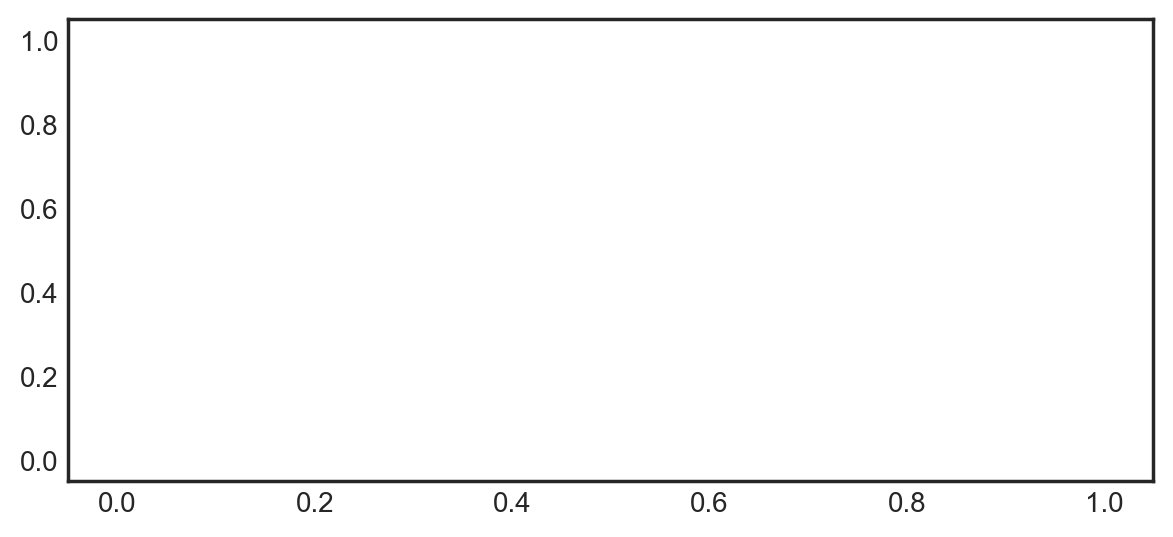

In [58]:
plot_converage_analysis_Fig6(df_RQI_results_final, hue_name='method_name', show_plot=True, outputdir=outputdir)

In [ ]:
# df_RQI_results_final.sort_values(by=['threshold'])
df_RQI_results_final['method_name'].unique()

In [ ]:
def plot_errorVcoverage(df_RQI_results, ax, ax2, alpha=1):

    fontsize = 10

    ax.plot(df_RQI_results['threshold'].values, df_RQI_results['MAE'].values, color='steelblue', zorder=2, alpha=alpha)
    ax.scatter(df_RQI_results['threshold'].values, df_RQI_results['MAE'].values, s=15, facecolors='white', edgecolors='steelblue', zorder=3, alpha=alpha)

    ax.set_ylabel("MAE (BPM)",fontsize=fontsize, color='steelblue')
    ax.set_xlabel('threshold',fontsize=fontsize)

#     ax2=ax.twinx()

    ax2.plot(df_RQI_results['threshold'].values, df_RQI_results['coverage'].values, color='firebrick', zorder=1, alpha=alpha)
    ax2.scatter(df_RQI_results['threshold'].values, df_RQI_results['coverage'].values, s=20, marker='x', color='firebrick', zorder=2, alpha=alpha)
    ax2.set_ylabel("coverage (%)",fontsize=fontsize,color='firebrick')

#     plt.show()


In [ ]:
df_RQI_results_final['method_name'].unique()



In [ ]:


fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=300)
ax2=ax.twinx()
for method_name in df_RQI_results_final['method_name'].unique():
#     print(method_name, df_RQI_results['MAE'].max()-df_RQI_results['MAE'].min())
    if method_name=='ST':
        continue
    if method_name=='UNet':
        alpha=0.5
        continue
    if method_name=='MA-UNet':
        alpha=1
#         continue
    df_RQI_results = df_RQI_results_final[df_RQI_results_final['method_name']==method_name]
#     print(df_RQI_results.shape)

    plot_errorVcoverage(df_RQI_results, ax, ax2, alpha=alpha)
    
    thre = 0.83
    method_name = 'MA-UNet'
    mask_df = (df_RQI_results_final['method_name']==method_name)
    df_RQI_results = df_RQI_results_final[mask_df]
    
    i_line = np.argmin(np.abs(df_RQI_results['threshold']-thre))
    x_value = df_RQI_results.iloc[i_line]['threshold']
    mae = df_RQI_results.iloc[i_line]['MAE']
    coverage = df_RQI_results.iloc[i_line]['coverage']
    ax.axvline(x=x_value, color='gray', linestyle='--', zorder=0, alpha=0.7, linewidth=2)
    
    print(x_value, mae, coverage)

    thre = 0
    method_name = 'MA-UNet'
    mask_df = (df_RQI_results_final['method_name']==method_name)
    df_RQI_results = df_RQI_results_final[mask_df]
    
    i_line = np.argmin(np.abs(df_RQI_results['threshold']-thre))
    x_value = df_RQI_results.iloc[i_line]['threshold']
    mae = df_RQI_results.iloc[i_line]['MAE']
    coverage = df_RQI_results.iloc[i_line]['coverage']
    ax.axvline(x=x_value, color='gray', linestyle='--', zorder=0, alpha=0.7, linewidth=2)

    print(x_value, mae, coverage)
    # (df_outputlabel_Fig6['RQI_fft']>thre).mean()    
    

#     ax.set_ylim(0.8,2.2)
#     ax2.set_ylim(75,105)

#     ax.set_xlim(0,1.2)

In [ ]:
# i

In [ ]:
# mask = df_RQI_results_final['method_name']=='MA-UNet'
# mask = df_RQI_results_final['method_name']=='UNet'
# df_RQI_results_final[mask]

In [ ]:
thre = 0.833
# method_name = 'ST'
# method_name = 'UNet'
method_name = 'MA-UNet'

mask_df = (df_outputlabel_Fig6['method_name']==method_name) & (df_outputlabel_Fig6['RQI_fft']>thre)
df_outputlabel = df_outputlabel_Fig6[mask_df]

(df_outputlabel_Fig6['RQI_fft']>thre).mean()

In [ ]:
df_performance_agg = get_df_performance_agg(df_outputlabel)
# df_performance_agg

In [ ]:
# df_performance_agg = df_performance_agg[df_performance_agg['method']=='U-Net-AT_block']
df_performance_agg = df_performance_agg[df_performance_agg['method']=='ST']
# df_performance_agg

In [ ]:
# df_outputlabel_Fig6['method_name'].unique()

In [ ]:
# for metric_name in ['MAE_mean', 'MAPE', 'RMSE', 'PCC', 'CoeffDeterm']:

#     print('{}: {:.2f}+/-{:.2f}'.format(metric_name, df_performance_agg[metric_name].mean(), df_performance_agg[metric_name].std()) )

# # df_performance_agg['MAE_mean'].mean(), df_performance_agg['MAE_mean'].std()

In [ ]:
# df_outputlabel['CV'].unique().shape

In [ ]:
# traning_dir = '../../data/stage4_UNet_backup/CDC_dataset/ECGPPG/AT_block/target'
# Estimation_EE/data/stage4_UNet/CDC_dataset/ECG-SR+PPG-select/AT_block/target/training_params.npz


traning_dir = inputdir + 'CDC_dataset/ECG-SR+PPG-select/AT_block/target/'
training_params = data_loader('training_params', traning_dir).item()
training_params['label_range'] = '4,61'

In [ ]:
training_params['show_metrics'] = True

In [ ]:
task = 'RR_cosmed'
plot_regression(df_outputlabel, task, training_params, single_color=True, fig_name='regression_{}'.format(method_name), show_plot=True, outputdir=outputdir)
# plot_regression(df_outputlabel, task, training_params, single_color=False, fig_name='regression_{}'.format(method_name), show_plot=True, outputdir=outputdir)

In [ ]:
plot_BA(df_outputlabel, task, training_params=training_params, single_color=True, fig_name='BA_{}'.format(method_name), show_plot=True, outputdir=outputdir)


In [ ]:
# df_RQI_results[df_RQI_results['RQI_name']=='RQI_kurtosis']

In [ ]:
# fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
# ax

In [ ]:
sys.exit()

In [ ]:
hue_color_dict

In [ ]:

df1 = df_performance_agg_joint[(df_performance_agg_joint['method']=='ST')&(df_performance_agg_joint['TF_type']=='target')].copy()
df1['hue_name'] = 'ST'

df2 = df_performance_agg_joint[(df_performance_agg_joint['method']=='ST RQI_fft')&(df_performance_agg_joint['TF_type']=='target')].copy()
df2['hue_name'] = 'ST RQI_fft'

method_name1 = 'U-Net'

df3 = df_performance_agg_joint[(df_performance_agg_joint['method']=='{}'.format(method_name1))&(df_performance_agg_joint['TF_type']=='target')].copy()
df3['hue_name'] = '{}'.format(method_name1)

df4 = df_performance_agg_joint[(df_performance_agg_joint['method']=='{} RQI_fft'.format(method_name1))&(df_performance_agg_joint['TF_type']=='target')].copy()
df4['hue_name'] = '{} RQI_fft'.format(method_name1)


method_name2 = 'U-Net-AT_block'

df5 = df_performance_agg_joint[(df_performance_agg_joint['method']=='{}'.format(method_name2))&(df_performance_agg_joint['TF_type']=='target')].copy()
df5['hue_name'] = '{}'.format(method_name2)

df6 = df_performance_agg_joint[(df_performance_agg_joint['method']=='{} RQI_fft'.format(method_name2))&(df_performance_agg_joint['TF_type']=='target')].copy()
df6['hue_name'] = '{} RQI_fft'.format(method_name2)




# df = pd.concat([df1, df2, df3, df4])
df = pd.concat([df1, df2, df3, df4, df5, df6])
hue_order = ['ST', 'ST RQI_fft', '{}'.format(method_name1), '{} RQI_fft'.format(method_name1), '{}'.format(method_name2), '{} RQI_fft'.format(method_name2)]
fig_name = 'Fig7Xmod_{}'.format(act_type)
plot_hue_compare(df, hue_order=hue_order, fig_name=fig_name, show_plot=True, outputdir=outputdir)


In [ ]:
N_sub = df['subject_id'].unique().shape[0]

In [ ]:
print('check coverage for {}\n'.format(act_type))

for method in ['ST RQI_fft', 'U-Net RQI_fft', 'U-Net-AT_block RQI_fft']:
    for modality in df['modality'].unique():
        mask = (df['method']==method) & (df['modality']==modality)
        if mask.sum()==0:
            continue
        coverage_arr = df[mask]['coverage'].values.copy()
        coverage_arr.resize(N_sub)
        print('{} | {}:\t\t{:.2f}+/-{:.2f}%'.format(method, modality, coverage_arr.mean(), coverage_arr.std()))
    print()

In [ ]:
sys.exit()

In [ ]:
from scipy.special import softmax


weights = np.random.rand(4, 2)

weights = softmax(weights,axis=-1)

In [ ]:
# weights = np.random.rand(20)

meta = np.ones(weights.shape[0])
meta[-weights.shape[0]//2:] = 2
t_arr = np.arange(1, weights.shape[0]+1, 1)

In [ ]:
plt.plot(t_arr, meta)
plt.scatter(t_arr, meta)
plt.grid()

plt.xticks(np.arange(1, weights.shape[0]+1, 1))
#     ax_task.set_xticklabels(np.arange(1, weights.shape[0]+1, 1))
#     ax_task.set_xticks(np.arange(-.5, weights.shape[0], 1), minor=True)
plt.xlim(0.5,t_arr.max()+0.5)

In [ ]:
    ax_task.plot(np.arange(1, weights.shape[0]+1, 1), meta[:,1])


In [ ]:
def plot_attention(weights):
    # weights dim: (N_sample, N_sig)

    gs0 = gridspec.GridSpec(1,2, width_ratios=[0.1, 10])
    fig = plt.figure(figsize=(weights.shape[0]/3,3), dpi=100)

    ax = fig.add_subplot(gs0[0,1])
    cax = fig.add_subplot(gs0[0,0])

    vmin = weights.min()
    vmax = weights.max()

    im = ax.imshow(weights.T , cmap='viridis', aspect="auto", origin='lower', vmin=vmin, vmax=vmax, interpolation='none',)

    ax.set_xticks(np.arange(0, weights.shape[0], 1))
    ax.set_yticks(np.arange(0, weights.shape[1], 1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(1, weights.shape[0]+1, 1))
    ax.set_yticklabels(np.arange(1, weights.shape[1]+1, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, weights.shape[0], 1), minor=True)
    ax.set_yticks(np.arange(-.5, weights.shape[1], 1), minor=True)

    ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)

    fig.colorbar(im, cax=cax)

    fig.tight_layout()

    plt.show()

In [ ]:
# plot_attention(weights)

# get_df_performance_agg playground

In [ ]:
method_color_dict = {
#     'temporal': '#2471A3',
    'ST': '#B1F2BE',
    'ST RQI_kurtosis':'#689B72' ,
    'U-Net':'#F3EBA1' ,
#     'U-Net RQI_fft':'#b34b45' ,
    'U-Net RQI_kurtosis':'#D2BB6E' ,
    'U-Net RQI_fft':'#B2C110' ,
    
    'U-Net-SE_block':'#F696A6' ,
    'U-Net-SE_block RQI_kurtosis':'#C05365' ,
    'U-Net-SE_block RQI_fft':'#C4580C' ,
}

In [ ]:
# # task = 'Baseline'
# # method = 'U-Net'
# TF_type = 'target'
# # df = df_performance_agg_joint[(df_performance_agg_joint['TF_type']==TF_type) & ((df_performance_agg_joint['method']==method) | (df_performance_agg_joint['method']==method+' RQI_kurtosis')) ]
# df = df_performance_agg_joint[(df_performance_agg_joint['TF_type']==TF_type)]


In [ ]:
# def plot_TF_compare(df):
#     metric_name = 'MAE_mean'

#     fig, ax = plt.subplots(1,1, figsize=(7,5),dpi=250)

#     # sns.violinplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, palette=TF_color_dict)
#     sns.boxplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, palette=TF_color_dict, hue_order=list(TF_color_dict.keys()),  
#                 showmeans=True,
#                 meanprops={"marker":"o",
#                            "markerfacecolor":"white", 
#                            "markeredgecolor":"black",
#                           "markersize":"5"},
#                )    
# #     sns.swarmplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, color='black', hue_order=list(TF_color_dict.keys()), dodge=True, size=3, alpha=0.8)

#     # get the lowest MAE
#     MAE_lowest = []
#     for TF_type in df['TF_type'].unique():
#         for modality in df['modality'].unique():
#             MAE_lowest.append( df[(df['modality']==modality) & (df['TF_type']==TF_type)][metric_name].mean() )
#     MAE_lowest = min(MAE_lowest)
    
#     # xmin and xmax 
#     xmin = -.8
#     xmax = df['modality'].unique().shape[0]-1+0.8
#     ax.hlines(y=MAE_lowest, xmin=xmin, xmax=xmax, linewidth=3, color='#627565', alpha=0.5)
#     ax.set_xlim(xmin,xmax)

#     ax.yaxis.grid(True, which='major', color='gray',alpha=0.8)
#     ax.yaxis.grid(True, which='minor', alpha=0.5)
#     ax.legend(frameon=True, bbox_to_anchor=(1.05,1))
#     ax.set_ylim(0,4)
#     ax_no_top_right(ax)
#     plt.show()

In [ ]:
def plot_figure4(df, outputdir=None, show_plot=False):

    x_name = 'modality'
    y_name = 'MAE_mean'
    hue_name = 'method'
    col_name = 'task'
    metric_name = 'MAE_mean'
    
    hue_order = ['ST', 'U-Net', 'U-Net-SE_block']

    N_hue = len(df[hue_name].unique())
    N_modality = len(df[x_name].unique())

    # fig, ax = plt.subplots(1,1, figsize=(N_hue*15,5),dpi=150)

    fig, ax = plt.subplots(1,1, figsize=(N_modality,6),dpi=180)

    sns.boxplot(data=df, x=x_name, y=y_name, hue=hue_name, ax=ax, boxprops=dict(linewidth=1, alpha=0.7), showfliers = True, palette=method_color_dict, hue_order=hue_order,
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"},
               )    
    
#     sns.stripplot(data=df, x=y_name, y=x_name, hue=hue_name, ax=ax, dodge=True, size=2, color='black', alpha=0.9, hue_order=hue_order)

    # get the lowest MAE
    MAE_lowest = []
    for method in df['method'].unique():
        for modality in df['modality'].unique():
            MAE_lowest.append( df[(df['modality']==modality) & (df['method']==method)][metric_name].mean() )
    MAE_lowest = min(MAE_lowest)
    MAE_lowest
    # xmin and xmax 
    xmin = -.8
    xmax = df['modality'].unique().shape[0]-1+0.8
    ax.hlines(y=MAE_lowest, xmin=xmin, xmax=xmax, linewidth=3, color='#627565', alpha=0.5)
    ax.set_xlim(xmin,xmax)
    
#     ax.set_xlim(0,8)
    # ax.set_xscale("log")


    # ax.legend().set_visible(False)
    ax_no_top_right(ax)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # ax.hlines(y=1, xmin=xmin-0.5, xmax=xmax, linewidth=1, color='gray', alpha=0.5)
    # ax.set_xlim(0, xmax)

    ax.legend().set_visible(False)


    handles, labels = ax.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the last two.
    # l = plt.legend(handles[:N_hue], labels[:N_hue], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    l = plt.legend(handles[:N_hue], labels[:N_hue], loc='upper right', borderaxespad=0.)


#     minor_ticks = np.arange(0, 10, 0.25)
#     ax.set_yticks(minor_ticks, minor=True)
   
    ax.yaxis.grid(True, which='major', color='gray',alpha=0.8)
    
#     ax.yaxis.set_minor_locator(AutoMinorLocator(4))
#     ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.grid(True, which='minor', color='gray', alpha=0.2)

    ax.minorticks_on()

#     ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax.legend(frameon=True, bbox_to_anchor=(1.05,1))
    ax.set_ylim(0,ymax)
    ax_no_top_right(ax)
    fig.tight_layout()


    
    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'figure4.png', facecolor=fig.get_facecolor())
        
    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
    plt.show()


In [ ]:
TF_type = 'target'
df = df_performance_agg_joint[(df_performance_agg_joint['TF_type']==TF_type)]
# df = df[(df['method']!='ST RQI_kurtosis') & (df['method']!='U-Net RQI_kurtosis') & (df['method']!='U-Net-SE_block RQI_kurtosis')]
# df = df[(df['method']=='ST') | (df['method']=='U-Net') | (df['method']=='U-Net-SE_block')]
df = df[(df['method']=='ST') | (df['method']=='U-Net')]
plot_figure4(df, outputdir=outputdir, show_plot=True)



In [ ]:
# TF_type = 'source'
# df = df_performance_agg_joint[(df_performance_agg_joint['TF_type']==TF_type)]
# # df = df[(df['method']!='ST RQI_kurtosis') & (df['method']!='U-Net RQI_kurtosis') & (df['method']!='U-Net-SE_block RQI_kurtosis')]
# df = df[(df['method']=='ST') | (df['method']=='U-Net-SE_block')]
# plot_figure4(df, outputdir=outputdir, show_plot=True)



In [ ]:
# minor_ticks

In [ ]:
def plot_MAE_4task(df):

    x_name = 'modality'
    y_name = 'MAE_mean'
    hue_name = 'method'
    col_name = 'task'

    N_hue = len(df[hue_name].unique())

    # fig, ax = plt.subplots(1,1, figsize=(N_hue*15,5),dpi=150)

    fig = plt.figure(figsize=(N_hue*3,5), constrained_layout=True, dpi=120)


    hue_order = ['ST', 'ST RQI_kurtosis', 'U-Net', 'U-Net RQI_kurtosis']

    N_tasks = df['task'].unique().shape[0]
    gs = gridspec.GridSpec(N_tasks, 1)

    for i_task, task in enumerate(df['task'].unique()):
        df_task = df[df['task']==task]
        ax = fig.add_subplot(gs[i_task, 0])

        sns.boxplot(data=df_task, x=x_name, y=y_name, hue=hue_name, ax=ax, boxprops=dict(linewidth=1, alpha=0.7), showfliers = False, palette=method_color_dict, hue_order=hue_order)
        sns.stripplot(data=df_task, x=x_name, y=y_name, hue=hue_name, ax=ax, dodge=True, size=2, color='black', alpha=0.9, hue_order=hue_order)

        ax.set_ylim(0,5)

        ax.set_title(task)
        ax.legend().set_visible(False)
        ax_no_top_right(ax)

        xmin, xmax = ax.get_xlim()

        ax.hlines(y=1, xmin=xmin-0.5, xmax=xmax-0.5, linewidth=1, color='gray', alpha=0.5)
        ax.set_xlim(xmin, xmax)

    ax.legend().set_visible(True)

    handles, labels = ax.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the last two.
    l = plt.legend(handles[:N_hue], labels[:N_hue], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.tight_layout()



In [ ]:
TF_type = 'target'
df = df_performance_agg_joint[(df_performance_agg_joint['TF_type']==TF_type)]
plot_MAE_4task(df)


In [ ]:
def plot_MAE_4methodTF(df):

    N_modality = len(df['modality'].unique())

    fig, ax = plt.subplots(1,1, figsize=(N_modality*1.5,3),dpi=100)

    # average over subjects
    sns.boxplot(data=df, x='task', y='MAE_mean', hue='modality', ax=ax, boxprops=dict(linewidth=1, alpha=0.7), showfliers = False)
    sns.stripplot(data=df, x='task', y='MAE_mean', hue='modality', ax=ax,dodge=True, size=2, color='black', alpha=0.9)


    handles, labels = ax.get_legend_handles_labels()

    # When creating the legend, only use the first two elements
    # to effectively remove the last two.
    l = plt.legend(handles[:N_modality], labels[:N_modality], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    modality = df['modality'].unique()[0]
    TF_type = df['TF_type'].unique()[0]
    
    ax.set_title('method: {}\nTF_type:{}'.format(method, TF_type))
    ax_no_top_right(ax)
    
    xmin, xmax = ax.get_xlim()
#     print( xmin, xmax)

    ax.hlines(y=1, xmin=-1, xmax=4, linewidth=1, color='gray', alpha=0.5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0,4)

In [ ]:
show_each_modality = False

if show_each_modality:
    for TF_type in df_performance_agg_joint['TF_type'].unique():
        for method in df_performance_agg_joint['method'].unique():
            df = df_performance_agg_joint[(df_performance_agg_joint['TF_type']==TF_type) & (df_performance_agg_joint['method']==method)]
    #         df = df[df['modality']!='SCG']
            plot_MAE_4methodTF(df)

# print metrics for all tasks together

In [ ]:
print('modality\tMAE_mean\tMAE_std\t\tPCC\t\tRsqr')

# TF_type = 'target'
TF_type = 'target'
est_method = 'U-Net'
# est_method = 'U-Net-SE_block'
# est_method = 'ST'

for modality in df_outputlabel_ALL_selected['modality'].unique():
    df = df_outputlabel_ALL_selected[(df_outputlabel_ALL_selected['est_method']==est_method) & (df_outputlabel_ALL_selected['TF_type']==TF_type) & (df_outputlabel_ALL_selected['modality']==modality)]

    
    MAE_mean, MAE_std = get_MAE(df['label'], df['label_est'])
    PCC = get_PCC(df['label'], df['label_est'])
    Rsqr = get_CoeffDeterm(df['label'], df['label_est'])
    print('{}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}'.format(modality, MAE_mean, MAE_std, PCC, Rsqr))
#     print(MAE_mean, MAE_std, PCC, Rsqr)
    # df_outputlabel_ALL['label_est']

In [ ]:
def get_df_TF_agg(df, metric='MAE_mean'):
#     df_TF_agg = df_performance_agg[df_performance_agg['method']==method].copy()
    df_TF_agg = df.pivot_table(index="TF_type", columns="modality", values=metric, aggfunc='mean')
#     print(df_TF_agg)
#     sys.exit()
#     df_TF_agg = df_TF_agg.loc[list_TF_types]
    df_TF_agg = df_TF_agg[list(df['modality'].unique())]
    return df_TF_agg

# check MAE of all modalities vs. method

In [ ]:
def print_df_performance_agg(df_performance_agg):
    use_TEST=False

    remove_moving=True

    df_TF_agg = pd.DataFrame()

    for method in list_method:
    #     print(method)

        if use_TEST :
            df = df_performance_agg[ (df_performance_agg['subject_id'].isin([1, 5, 7, 15, 16, 22])) & (df_performance_agg_GT_TEST['method']==method)].copy()
        # df_performance_agg_GT_TEST = df_performance_agg
        else:
            df = df_performance_agg[df_performance_agg['method']==method].copy()

        if remove_moving:
            df = df[df['task']!='6MWT']
            
#         print(df)
#         sys.exit()
        
#         def allbut(*names):
#             names = set(names)
#             return [item for item in levels if item not in names]
#         df.groupby(level=allbut('subject_id')).mean()
#         print(df)
#         sys.exit()


        df['TF_type'] = df['method'] + ' ' + df['TF_type']
        df_TF_agg = df_TF_agg.append(get_df_TF_agg(df, metric='MAE_mean'))

    df_TF_agg = df_TF_agg.drop('ST source')
    df_TF_agg = df_TF_agg.rename(index={'ST target':'ST'})
    display(df_TF_agg)


In [ ]:
print_df_performance_agg(df_performance_agg_joint)


In [ ]:
# df_performance_agg_copy = df_performance_agg_joint.copy()
# df_copy = df_performance_agg_copy[df_performance_agg_copy['method']=='U-Net RQI_fft'].copy()
# df_copy.pivot_table(index="TF_type", columns="modality", values="MAE_mean", aggfunc='first')
# # df_performance_agg_copy

In [ ]:
df_performance_agg_copy = df_performance_agg_joint.copy()
# df_copy = df_performance_agg_copy[df_performance_agg_copy['method']=='U-Net RQI_kurtosis'].copy()
df_copy = df_performance_agg_copy[df_performance_agg_copy['method']=='U-Net RQI_fft'].copy()
df_copy.pivot_table(index="TF_type", columns="modality", values="MAE_mean", aggfunc=np.mean)
# df_performance_agg_copy

In [ ]:
# df

In [ ]:
# method_color_dict

In [ ]:
# method_color_dict

In [ ]:
metric_name = 'MAE_mean'

df = df_performance_agg_joint.copy()
df = df[(df['method']=='U-Net') | (df['method']=='U-Net RQI_kurtosis')]
# df = df[(df['method']=='U-Net') | (df['method']=='U-Net RQI_fft')]

df['method'] = pd.Categorical(
            df['method'], 
            categories=list_method,
            ordered=True
        )
df = df.sort_values('method')


df['modality'] = pd.Categorical(
            df['modality'], 
            categories=list_modalitites.reverse(), 
            ordered=True
        )
df = df.sort_values('modality')

fig, ax = plt.subplots(1,1, figsize=(7,3),dpi=180)

sns.barplot(x="modality", y=metric_name, hue="method", data=df, ax=ax, palette=method_color_dict)
ax.yaxis.grid(True, which='major', color='gray',alpha=0.8)
ax.yaxis.grid(True, which='minor', alpha=0.5)
ax.legend(frameon=True, bbox_to_anchor=(1.05,1))

ax_no_top_right(ax)
plt.show()

In [ ]:
def plot_figure_ranking_all(df_performance_agg, outputdir=None, show_plot=False):

#     df_performance_agg = df_performance_agg_joint.copy()


    fig = plt.figure(figsize=(7,7),dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    fontsize = 15

    # Width of a bar 
    width = 0.2
    model_shift = 0 + width*1.5

    # ind = np.arange(len(df['input_name'].unique()))
    #     ind = np.asarray([0, 1, 2, 3, 4, 6, 5, 7])
    # ind = np.arange(len(df_performance_agg['modality'].unique()))

    #     list_modalitites = ['SCG', 'PPG', 'ECG', 'SCGPPG', 'ECGSCG', 'ECGPPG', 'All']
    list_modalitites = ['SCG', 'PPG', 'ECG', 'SCGPPG', 'ECGSCG', 'ECGPPG', 'All']

    ind = np.arange(len(list_modalitites))

    # df = df_performance_agg.copy()


    # for method in df_performance_agg['method'].unique():
    #     for method in ['U-Net RQI_kurtosis', 'U-Net RQI_fft', 'U-Net', 'ST']:
    for method in ['U-Net RQI_kurtosis','U-Net RQI_fft', 'U-Net']:
        df = df_performance_agg.copy()

    #     df = df_performance_agg[df_performance_agg['method']==method].copy()

        df = df[(df['method']==method) & (df['TF_type']=='target') & (df['modality']!='selected')]


        df['modality'] = pd.Categorical(
            df['modality'], 
            categories=list_modalitites, 
            ordered=True
        )

        df = df.groupby(['modality']).mean()

    #     print(df)
    #     sys.exit()


    #     sys.exit()
    #     df = df.sort_values('modality')
    #     sys.exit()

    #     legend_name = method
    #     if method=='ST+U-Net':
    #         legend_name = 'ST-U-Net'
    #         print(df)

    #     print(df)
        ax.barh(ind+model_shift, df['MAE_mean'].values , width, label=method, color=method_color_dict[method], zorder=3, alpha=1)
    # ax.barh(ind, MAE_input_single,  width, label='Demodulation', color='firebrick', zorder=3, alpha=0.9)

    #     ax.hlines(ind+model_shift, 0, df['MAE_std'].values, color='black')  # Stems
    #     ax.plot(df['MAE_std'].values, ind+model_shift, 'o', color='black')  # Stem ends


    #         height = rect.get_height()
    #         print(df['MAE_std'].values, ind+model_shift)


    #         for (x_value, y_value, coverage) in zip(df['MAE_std'].values, ind+model_shift, df['coverage']):
        for (x_value, y_value, coverage) in zip(df['MAE_mean'].values*0, ind+model_shift, df['coverage']):
            if 'RQI' not in method:
                continue

    #             print(x_value, y_value, coverage)
            ax.text(x_value+0.05, y_value, 'cov={:.1f}%'.format(coverage), ha='left', va='center', fontsize=fontsize*0.5, color='black',weight='bold')



        model_shift = model_shift - width


    ax.set_yticks(ind + (width-0.05) / 2)
    ax.set_yticklabels(list_modalitites)


    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('MAE (bpm)', fontsize=fontsize+5)

    ax.legend(fontsize=fontsize, frameon=True, bbox_to_anchor=(1.04,1))
    ax.xaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.xaxis.grid(True, which='minor', alpha=0.5)
    # plt.majorticks_on() 
    plt.minorticks_on() 

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.tight_layout()

    #         ax.set_xlim(0,4)

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'figure_rank_all.png', facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
    plt.show()

    # plot_figure7_ranking_all(df_join_methods, outputdir=outputdir, show_plot=True)


In [ ]:
df_performance_agg_joint

In [ ]:
plot_figure_ranking_all(df_performance_agg_joint, outputdir=outputdir, show_plot=True)


# RQI analysis (coverage vs. MAE)
## target only

In [ ]:
df_RQI_results_final = pd.DataFrame()

for modality in df_outputlabel_ALL['modality'].unique():
    for est_method in df_outputlabel_ALL['est_method'].unique():
#     for est_method in ['ST', 'U-Net']:
        mask_df = (df_outputlabel_ALL['modality']==modality) & (df_outputlabel_ALL['est_method']==est_method) & (df_outputlabel_ALL['TF_type']=='target')
        df_outputlabel = df_outputlabel_ALL[mask_df]
        
        for RQI_name in ['random', 'RQI_kurtosis', 'RQI_fft', 'RQI_ideal']:
            df_RQI_results = get_df_RQI_results(df_outputlabel, RQI_name, steps_thre=steps_thre)
            df_RQI_results['RQI_name'] = RQI_name
            df_RQI_results['est_method'] = est_method
            df_RQI_results['modality'] = modality

            df_RQI_results_final = df_RQI_results_final.append(df_RQI_results)

In [ ]:
df_RQI_results_final['RQI_name'].unique()

In [ ]:
# df_RQI_results[df_RQI_results['RQI_name']=='RQI_kurtosis']

In [ ]:
# df_RQI_results_final['est_method'].unique()

In [ ]:
RQI_color_dict = {
    'random': '#999898', # gray
    'RQI_ideal':'#433F3F' , # black
    'RQI_fft':'#b34b45' , # red
    'RQI_kurtosis':'#c4751b' , # orange
}

def plot_MAEoverCoverage(ax, df_RQI_results, modality, est_method):
    fontsize = 10
    sns.lineplot(data=df_RQI_results, x="coverage", y="MAE", hue="RQI_name",ax=ax, palette=RQI_color_dict,alpha=0.8)
    ax.invert_xaxis()
    ax_no_top_right(ax)
    ax.set_xlim(100,50)
    ax.set_ylim(0,6)
    ax.set_xlabel('Coverage (%)', fontsize=fontsize)
    ax.set_ylabel('MAE (BPM)', fontsize=fontsize)
    ax.set_title('{}\n({})'.format(modality, est_method), fontsize=fontsize+3)
    ax.legend().set_visible(False)


def plot_converage_analysis(df_RQI_results_final):

#     N_est_method = len(df_RQI_results_final['est_method'].unique())
    list_est = ['U-Net-SE_block']
    N_modality = len(df_RQI_results_final['modality'].unique())

    fig, axes = plt.subplots(len(list_est), N_modality, figsize=(N_modality*1.5, 2), dpi=200, squeeze=False)
    #     fig, axes = plt.subplots(nrows=len(list_met), ncols=N_modality, figsize=(12,4), dpi=150)


    list_modalitites = list(df_RQI_results_final['modality'].unique())
    for i_mod, modality in enumerate(list_modalitites):
    #         for i_est, est_method in enumerate(df_RQI_results_final['est_method'].unique()):
        for i_est, est_method in enumerate(list_est):
    #         print(i_mod, i_est)
            mask_df = (df_RQI_results_final['modality']==modality) & (df_RQI_results_final['est_method']==est_method)
            df_RQI_results = df_RQI_results_final[mask_df]
            ax = axes[i_est, i_mod]
            plot_MAEoverCoverage(ax, df_RQI_results, modality, est_method)
    #         ax.legend( bbox_to_anchor=(1.04,1.04))
    fig.tight_layout()

In [ ]:
plot_converage_analysis(df_RQI_results_final)

# pretain vs. source vs. target

In [ ]:
TF_color_dict = {
    'ST': '#F5F4E0',
    'source': '#D8D7C5',
    'target': '#B8B7A9',
    'U-Net RQI_fft': '#6A7E7B',
#     'source': '#F5F4E0',
#     'target': '#D8D7C5',
#     'pretrain': '#B8B7A9',
}


In [ ]:
def plot_TF_compare(df):
    metric_name = 'MAE_mean'

    fig, ax = plt.subplots(1,1, figsize=(7,5),dpi=250)

    # sns.violinplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, palette=TF_color_dict)
    sns.boxplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, palette=TF_color_dict, hue_order=list(TF_color_dict.keys()),  
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"},
               )    
#     sns.swarmplot(x="modality", y=metric_name, hue="TF_type", data=df, ax=ax, color='black', hue_order=list(TF_color_dict.keys()), dodge=True, size=3, alpha=0.8)

    # get the lowest MAE
    MAE_lowest = []
    for TF_type in df['TF_type'].unique():
        for modality in df['modality'].unique():
            MAE_lowest.append( df[(df['modality']==modality) & (df['TF_type']==TF_type)][metric_name].mean() )
    MAE_lowest = min(MAE_lowest)
    
    # xmin and xmax 
    xmin = -.8
    xmax = df['modality'].unique().shape[0]-1+0.8
    ax.hlines(y=MAE_lowest, xmin=xmin, xmax=xmax, linewidth=3, color='#627565', alpha=0.5)
    ax.set_xlim(xmin,xmax)

    ax.yaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.yaxis.grid(True, which='minor', color='gray', alpha=0.2)
    ax.minorticks_on()
    
    ax.legend(frameon=True, bbox_to_anchor=(1.05,1))
    ax.set_ylim(0,25)
    ax_no_top_right(ax)
    plt.show()

In [ ]:
df1 = df_performance_agg_joint[(df_performance_agg_joint['method']=='U-Net')].copy()

df2 = df_performance_agg_joint[(df_performance_agg_joint['method']=='ST')&(df_performance_agg_joint['TF_type']=='target')].copy()
df2['TF_type'] = 'ST'

df3 = df_performance_agg_joint[(df_performance_agg_joint['method']=='U-Net RQI_fft') & (df_performance_agg_joint['TF_type']=='target')].copy()
df3['TF_type'] = 'U-Net RQI_fft'

df = pd.concat([df1, df2, df3])
plot_TF_compare(df)

In [ ]:
# df = df_performance_agg_joint[(df_performance_agg_joint['method']=='U-Net')].copy()


# plot RR vs. HR MAE color coded
# plot VT vs. HR MAE color coded

In [ ]:
# label_range_dict

In [ ]:
def plot_MAE_variable(df, var_name='HR_val'):
    f, ax = plt.subplots(dpi=100)
    sns.boxplot(x='MAE', y=var_name, data=df, ax=ax)
#     sns.violinplot(x='MAE', y=var_name, data=df, ax=ax)
    ax.set_xlabel('MAE')
    ax.set_ylabel(var_name)
    ax_no_top_right(ax)

In [ ]:

modality = 'All'
TF_type = 'target'
est_method = 'U-Net-SE_block'
df = df_outputlabel_ALL_selected[ (df_outputlabel_ALL_selected['modality']==modality) & (df_outputlabel_ALL_selected['est_method']==est_method) & (df_outputlabel_ALL_selected['TF_type']==TF_type) ].copy()
df['MAE'] = np.abs(df['RQI_ideal'])
df

## RR = 0.5 HR (Nyquist theorem)

ax + by + c = 0
given (x1, y1), what is the shortest distance from this point to the line

(| a*x1 + b*y1 + c |) / (sqrt( $a^{2}$ + $b^{2}$))

#### 0.5 HR - RR + 0 = 0 (a=0.5, b=-1, c=0)
#### given $HR_{sample}$ and $RR_{sample}$
distance = (| 0.5 * $HR_{sample}$ - 1 * $RR_{sample}$ + 0 |) / (sqrt( $0.5^{2}$ + $1^{2}$))

In [ ]:

def shortest_distance(df, RR_name, HR_name):
    y_arr = df[RR_name].values
    x_arr = df[HR_name].values

    distance2Nyquist = np.abs(x_arr * 0.5 - y_arr) / np.abs(0.5**2 + 1**2)
    return distance2Nyquist

In [ ]:
df['distance2Nyquist'] = shortest_distance(df, RR_name='label', HR_name='HR_val')


In [ ]:
# df

In [ ]:
# plt.scatter(df['VT_val'].values, df['MAE'].values, alpha=0.1)

In [ ]:
plot_MAE_variable(df, var_name='HR_val')
plot_MAE_variable(df, var_name='label')
plot_MAE_variable(df, var_name='VT_val')
plot_MAE_variable(df, var_name='distance2Nyquist')


In [ ]:
def plot_MAE_colored(df, x_name='HR_val', y_name='VT_val', c_name='RQI_ideal'):

    cmap = plt.get_cmap('viridis')

    f, ax = plt.subplots(dpi=100)
#     points = ax.scatter(df[x_name].values, df[y_name].values, c=np.abs(df[c_name].values), s=10, cmap=cmap, alpha=0.8,  vmin=0, vmax=3, zorder=3)
    points = ax.scatter(df[x_name].values, df[y_name].values, c=np.abs(df[c_name].values), s=10, cmap=cmap, alpha=0.7, zorder=3)

    if (x_name=='HR_val') & (y_name=='label'):
        RR = np.linspace(label_range_dict['RR'][0], label_range_dict['RR'][1], 100)
        HR = np.linspace(label_range_dict['HR'][0], label_range_dict['HR'][1], 100)

        ax.fill_between(HR, 0, HR/2, color='skyblue', alpha=0.2, label='Nyquist criterion\n'+r'$\frac{HR}{RR}$ > 2', zorder=1)
        ax.fill_between(HR, RR[-1], HR/2, color='gray', alpha=0.2, zorder=1)
        ax.set_ylim(label_range_dict['RR'])
        ax.set_xlim(label_range_dict['HR'])
    
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    f.colorbar(points)
    ax_no_top_right(ax)

In [ ]:
plot_MAE_colored(df, x_name='HR_val', y_name='VT_val', c_name='RQI_ideal')
plot_MAE_colored(df, x_name='HR_val', y_name='VT_val', c_name='RQI_ideal')
plot_MAE_colored(df, x_name='HR_val', y_name='label', c_name='RQI_ideal')
plot_MAE_colored(df, x_name='label', y_name='VT_val', c_name='RQI_ideal')
plot_MAE_colored(df, x_name='MAE', y_name='VT_val', c_name='RQI_ideal')


# WIP

In [ ]:
def inspect_Nyquist_color(RR_label, hr, absolute_err, sig_name, names_dict, outputdir=None, show_plot=False, show_label=True):

    plt.rcParams["font.family"] = "Times New Roman"

    RR = np.linspace(label_range_dict['br'][0], label_range_dict['br'][1], 100)
    HR = np.linspace(label_range_dict['heart_rate_cosmed'][0], label_range_dict['heart_rate_cosmed'][1], 100)

    
    RR_cosmed = RR_label
    HR_cosmed = hr

    mask = RR_cosmed * 2 < HR_cosmed

    if (~mask).sum() > 0:
        print('subject {} fall out of Nyquist region'.format(subject_id))

    fig, (ax1) = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    fontsize=18

#     ax1.fill_between(HR, 0, HR/2, color='skyblue', alpha=0.2, label='Nyquist criterion\n'+r'($F_{signal}$ < $\frac{1}{2}$$F_{sampling}$)')
    ax1.fill_between(HR, 0, HR/2, color='skyblue', alpha=0.2, label='Nyquist criterion\n'+r'$\frac{HR}{RR}$ > 2')
    ax1.fill_between(HR, RR[-1], HR/2, color='gray', alpha=0.2)

    cmap = matplotlib.cm.get_cmap('jet')
    bounds=np.arange(0, 8.1, 0.05)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    
    sc = ax1.scatter(HR_cosmed[np.where(mask)], RR_cosmed[np.where(mask)], s=50, c=absolute_err, alpha=1, cmap='jet', norm=norm)

#     title_str = '{}'.format(sig_name)
    title_str = names_dict[sig_name]

    
    if show_label:
#         ax1.set_title(title_str, fontsize=fontsize, pad=15)

        ax1.set_ylabel(r'$F_{signal}$ (RR, breaths/minute)', fontsize=fontsize)
        ax1.set_xlabel(r'$F_{sampling}$ (HR, beats/minute)', fontsize=fontsize)
        ax1.legend(frameon=True, loc='upper right', fontsize=fontsize-2)

    ax1.set_xlim(HR[0], HR[-1])
    ax1.set_ylim(RR[0], RR[-1])
    ax1.tick_params(axis = 'both', which = 'major', labelsize = fontsize)

    ax1.xaxis.set_major_locator(MultipleLocator(40))
                        
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.08)

    cbar = fig.colorbar(sc, cax=cax, boundaries=bounds, 
         ticks=[0,2,4,6,8],)  
    cbar.ax.tick_params(labelsize=fontsize-2) 

    fig.tight_layout()


    if outputdir is not None:
        outputdir = outputdir+'inspect_Nyquist/'
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + '{}.png'.format(sig_name), facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')


In [ ]:
for sig_name in names_dict:

    RR_label = RR_aggregated_dict[sig_name]['RR_label'].values*60
    RR_model = RR_aggregated_dict[sig_name]['RR_model'].values*60
    hr =  RR_aggregated_dict[sig_name]['hr'].values

    absolute_err = np.abs(RR_model-RR_label)
    inspect_Nyquist_color(RR_label, hr, absolute_err, sig_name, names_dict, outputdir=outputdir, show_plot=False, show_label=True)


In [ ]:
sys.exit()

In [ ]:
df_RQI_results

In [ ]:
list_modalitites

In [ ]:

# mask_df = (df_RQI_results_final['modality']=='All') & (df_RQI_results_final['est_method']=='U-Net') & (df_RQI_results_final['RQI_name']=='RQI_kurtosis')
mask_df = (df_RQI_results_final['modality']=='All') & (df_RQI_results_final['est_method']=='U-Net') & (df_RQI_results_final['RQI_name']=='RQI_fft')
df_RQI_results = df_RQI_results_final[mask_df]
plt.plot(df_RQI_results['coverage'].values, df_RQI_results['MAE'].values)

In [ ]:
df_RQI_results_final

In [ ]:
label = df_outputlabel_val_RR_cosmed['label']
label_est = df_outputlabel_val_RR_cosmed['label_est']

MAE, _ = get_MAE(label, label_est)
print(MAE)

In [ ]:
plt.plot(df_outputlabel_val_RR_cosmed['RQI_fft'])

mask_RQI_fft = df_outputlabel_val_RR_cosmed['RQI_fft'] > 0.1

In [ ]:
# df_outputlabel_val_RR_cosmed


In [ ]:
plt.plot(df_outputlabel_val_RR_cosmed['RQI_kurtosis'])

mask_RQI_kurtosis = df_outputlabel_val_RR_cosmed['RQI_kurtosis'] > 10

In [ ]:
label = df_outputlabel_val_RR_cosmed['label'][mask_RQI_fft & mask_RQI_kurtosis]
label_est = df_outputlabel_val_RR_cosmed['label_est'][mask_RQI_fft & mask_RQI_kurtosis]

MAE, _ = get_MAE(label, label_est)
print(MAE)

In [ ]:
plt.scatter(df_outputlabel_val_RR_cosmed['RQI_fft'], df_outputlabel_val_RR_cosmed['RQI_kurtosis'])

In [ ]:
mask_RQI.shape

In [ ]:
# for i in range(6):
#     mask_random = get_mask_random(2, 1, i_seed=i)
#     print(mask_random)

In [ ]:
# get_mask_random(1, 2, i_seed=1)


In [ ]:
# plt.plot(label_est)

In [ ]:
mask_random.astype(bool)

In [ ]:
# label[mask_random].shape, label.shape

In [ ]:
# RQI_fft_range
df_RQI_fft_results = pd.DataFrame()

RQI_fft_range = df_outputlabel_val_RR_cosmed['RQI_fft'].min(), df_outputlabel_val_RR_cosmed['RQI_fft'].max()

for threshold in np.linspace(RQI_fft_range[0],RQI_fft_range[1],steps_thre, endpoint=False):
    
    label = df_outputlabel_val_RR_cosmed['label'].values
    label_est = df_outputlabel_val_RR_cosmed['label_est'].values

    
    mask_RQI_fft = df_outputlabel_val_RR_cosmed['RQI_fft'] > threshold
    mask_RQI = mask_RQI_fft
    MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])
    
    N_ones = mask_RQI.sum()
    N_zeros = mask_RQI.shape[0] - mask_RQI.sum()
    
    mask_random = get_mask_random(N_zeros, N_ones)
    
#     print(mask_random.mean(), mask_RQI.mean())

#     label = df_outputlabel_val_RR_cosmed['label'][mask_random]
#     label_est = df_outputlabel_val_RR_cosmed['label_est'][mask_random]

    MAE_random, _ = get_MAE(label[mask_random], label_est[mask_random])
    
    
#     print(threshold, mask_RQI.mean(), MAE)
    
    df_RQI_fft_results = df_RQI_fft_results.append(
        pd.DataFrame(
            {
                'threshold': threshold,
                'rejection_ratio': 1-mask_RQI.mean(),
                'MAE': MAE,
                'MAE_random': MAE_random,
                
            }, index=[0]
    ))
    
df_RQI_fft_results = df_RQI_fft_results.reset_index(drop=True)

In [ ]:
threshold

In [ ]:
# RQI_fft_range
df_RQI_kurtosis_results = pd.DataFrame()

RQI_kurtosis_range = df_outputlabel_val_RR_cosmed['RQI_kurtosis'].min(), df_outputlabel_val_RR_cosmed['RQI_kurtosis'].max()

for threshold in np.linspace(RQI_kurtosis_range[0],RQI_kurtosis_range[1],steps_thre, endpoint=False):
    
    label = df_outputlabel_val_RR_cosmed['label'].values
    label_est = df_outputlabel_val_RR_cosmed['label_est'].values

    
    mask_RQI_kurtosis = df_outputlabel_val_RR_cosmed['RQI_kurtosis'] > threshold
        
    mask_RQI = mask_RQI_kurtosis
    MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])
    
    N_ones = mask_RQI.sum()
    N_zeros = mask_RQI.shape[0] - mask_RQI.sum()
    
    mask_random = get_mask_random(N_zeros, N_ones)
    
#     print(mask_random.mean(), mask_RQI.mean())

#     label = df_outputlabel_val_RR_cosmed['label'][mask_random]
#     label_est = df_outputlabel_val_RR_cosmed['label_est'][mask_random]

    MAE_random, _ = get_MAE(label[mask_random], label_est[mask_random])
    
    
#     print(threshold, mask_RQI.mean(), MAE)
    
    df_RQI_kurtosis_results = df_RQI_kurtosis_results.append(
        pd.DataFrame(
            {
                'threshold': threshold,
                'rejection_ratio': 1-mask_RQI.mean(),
                'MAE': MAE,
                'MAE_random': MAE_random,
                
            }, index=[0]
    ))
    
df_RQI_kurtosis_results = df_RQI_kurtosis_results.reset_index(drop=True)

In [ ]:
# RQI_fft_range
df_RQI_joint_results = pd.DataFrame()

RQI_kurtosis_range = df_outputlabel_val_RR_cosmed['RQI_kurtosis'].min(), df_outputlabel_val_RR_cosmed['RQI_kurtosis'].max()
RQI_fft_range = df_outputlabel_val_RR_cosmed['RQI_fft'].min(), df_outputlabel_val_RR_cosmed['RQI_fft'].max()


for threshold_fft in np.linspace(RQI_fft_range[0],RQI_fft_range[1],steps_thre, endpoint=False):

    for threshold_kurtosis in np.linspace(RQI_kurtosis_range[0],RQI_kurtosis_range[1],steps_thre, endpoint=False):

        label = df_outputlabel_val_RR_cosmed['label'].values
        label_est = df_outputlabel_val_RR_cosmed['label_est'].values

        # reject using both RQI_kurtosis and RQI_fft
        mask_RQI_kurtosis = df_outputlabel_val_RR_cosmed['RQI_kurtosis'] > threshold_kurtosis
        
        mask_RQI_fft = df_outputlabel_val_RR_cosmed['RQI_fft'] > threshold_fft
        mask_RQI = mask_RQI_kurtosis & mask_RQI_fft
        
        
        MAE, _ = get_MAE(label[mask_RQI], label_est[mask_RQI])

        
        # randomly reject samples
        N_ones = mask_RQI.sum()
        N_zeros = mask_RQI.shape[0] - mask_RQI.sum()

        mask_random = get_mask_random(N_zeros, N_ones)

        MAE_random, _ = get_MAE(label[mask_random], label_est[mask_random])


    #     print(threshold, mask_RQI.mean(), MAE)

        df_RQI_joint_results = df_RQI_joint_results.append(
            pd.DataFrame(
                {
                    'threshold_fft': threshold_fft,
                    'threshold_kurtosis': threshold_kurtosis,
                    'rejection_ratio': 1-mask_RQI.mean(),
                    'MAE': MAE,
                    'MAE_random': MAE_random,

                }, index=[0]
        ))

    df_RQI_joint_results = df_RQI_joint_results.reset_index(drop=True)

In [ ]:
plt.plot(df_RQI_joint_results['rejection_ratio']*100, df_RQI_joint_results['MAE'], 'r')
plt.show()

In [ ]:
plt.scatter(df_RQI_fft_results['rejection_ratio']*100, df_RQI_fft_results['MAE'], c='r', alpha=0.5)
plt.scatter(df_RQI_kurtosis_results['rejection_ratio']*100, df_RQI_kurtosis_results['MAE'], c='green', alpha=0.5)
plt.scatter(df_RQI_joint_results['rejection_ratio']*100, df_RQI_joint_results['MAE'], c='blue', alpha=0.01)

plt.show()

In [ ]:
plt.plot(df_RQI_fft_results['MAE_random'], df_RQI_fft_results['MAE'])

In [ ]:
plt.plot(df_RQI_fft_results[])

In [ ]:
sns.scatterplot(data=df_outputlabel_val_RR_cosmed, x='label', y='label_est', hue='CV', palette=subject_palette)

In [ ]:
# names_dict = {
#     'SCG_AMpt': r'SCG-PT$_{AM}$',
# #     'SCG_BW': r'SCG$_{BW}$',
# #     'PEP_FM': r'SCG$_{FM}$',
    
#     'ECG_AM': r'ECG$_{AM}$',
#     'ECG_AMr': r'ECG-R$_{AM}$',
#     'ECG_AMs': r'ECG-S$_{AM}$',
#     'ECG_AMbi': r'ECG-PP$_{AM}$',
#     'ECG_SR': r'ECG-SR$_{AM}$',
#     'ECG_AMpt': r'ECG-PT$_{AM}$',
#     'ECG_PCA': r'ECG-PCA$_{AM}$',
# #     'ECG_FM': r'ECG$_{FM}$',
# #     'ECG_BW': r'ECG$_{BW}$',
    
# #     'ECG_AMpt+ECG_AMr': r'ECG-PT$_{AM}$ + ECG-R$_{AM}$',
# #     'SCG_BW+SCG_AMpt': r'SCG$_{BW}$ + SCG-PT$_{AM}$',
# #     'ECG_AMpt+ECG_AMr+SCG_AMpt': r'ECG-PT$_{AM}$ + ECG-R$_{AM}$ + SCG-PT$_{AM}$',
#     'ECG_AMr+SCG_AMpt': r'ECG-R$_{AM}$ + SCG-PT$_{AM}$',    
# #     'ECG_AM+ECG_AMpt+ECG_AMr+ECG_AMs+ECG_AMbi+ECG_SR+SCG_AMpt': r'All ECG$_{AM}$ + SCG-PT$_{AM}$',
# #     'ECG_AM+ECG_AMpt+ECG_AMr+ECG_AMs+ECG_AMbi+ECG_SR':  r'All ECG$_{AM}$',
# #     'ECG_AMpt+ECG_AMr+ECG_AMbi+ECG_SR':  r'Good ECG$_{AM}$',
# #     'ECG_AMpt+ECG_AMr+ECG_AMbi+ECG_SR+SCG_AMpt': r'good ECG$_{AM}$ + SCG-PT$_{AM}$',
# }

In [ ]:
df_aggregated = pd.DataFrame()
for sub_file in os.listdir(inputdir):
    if 'script' in sub_file: 
        
        csv_dir = inputdir + sub_file + '/TRAIN-TEST/df_performance_TEST.csv'
#         print(csv_dir)
        
        try:
            df = pd.read_csv(csv_dir)  
            sig_name = '_'.join(sub_file.split('_')[3:-2])
            df['sig_name'] = sig_name

            df_aggregated = df_aggregated.append(df, ignore_index=True)
        except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
            print ('error when reading', sub_file)

In [ ]:
inputdir

In [ ]:
df_aggregated

In [ ]:
# filedir = '../../../covid/results/backup/stage3/win60_overlap95_seq20_ECG_AM_norm_script0/'
filedir = '../../../covid/results/stage3/win60_overlap95_seq20_ECG_AM_norm_script0/'

training_params = {}
freq = data_loader('freq', filedir)
freq_dict = dict(zip(np.arange(freq.shape[0]), freq))
training_params['freq_dict'] = freq_dict

In [ ]:
label_TRAIN = data_loader('label', filedir+'TRAIN_cosmed/')
RR_label_TRAIN = get_RR2(label_TRAIN, training_params)[:,10]*60

label_TEST = data_loader('label', filedir+'TEST/')
RR_label_TEST = get_RR2(label_TEST, training_params)[:,10]*60

In [ ]:
label_name = 'RR'

RR_range = label_range_dict['br']

fig=plt.figure(figsize=(6, 6), dpi= 120, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)

N_bins = 20

ax.hist(RR_label_TRAIN, N_bins, alpha=0.4, label='TRAIN\n  N=11\n  mean={:.2f}bpm'.format(RR_label_TRAIN.mean()), color = "firebrick")
ax.set_ylabel('count', fontsize = 20)
ax.set_xlabel(r'$RR$ (bpm)', fontsize = 20)
ax.set_title('RR samples distribution \n17 subjects, treadmill recovery ', fontsize = 20,y=1.05)
ax.tick_params(axis='x', which='major', labelsize=15)



# ax2 = fig.add_subplot(1, 2, 2)

ax.hist(RR_label_TEST, N_bins, alpha=0.4,label='TEST\n  N=6\n  mean={:.2f}bpm'.format(RR_label_TEST.mean()), color = "steelblue")

ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlim(RR_range)
# ax2.set_xlim(RR_range)
# ax.legend(loc='upper right', fontsize=12, frameon=True)
# ax.axis('off')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(True)

fig.tight_layout()
fig.savefig(outputdir + 'RR_distribution.png')

In [ ]:
df_aggregated = df_aggregated.sort_values(by=['MAE_mean_model_val'], inplace=False, ascending=False)
df_aggregated[['MAE_mean_model_val', 'sig_name']]
df_aggregated

In [ ]:
RR_aggregated_dict = {}
for sub_file in os.listdir(inputdir):
    if 'script' in sub_file: 
        
        csv_dir = inputdir + sub_file + '/TRAIN-TEST/df_RR_TEST.csv'
#         print(csv_dir)
        
        try:
            df = pd.read_csv(csv_dir)  
            sig_name = '_'.join(sub_file.split('_')[3:-2])
            df['sig_name'] = sig_name

#             df_RR_aggregated = df_RR_aggregated.append(df, ignore_index=True)
            RR_aggregated_dict[sig_name] = df.copy()
        except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
            print ('error when reading', sub_file)

In [ ]:
input_names = df_aggregated['sig_name'].values
MAE_model = df_aggregated['MAE_mean_model_val'].values
MAE_input = df_aggregated['MAE_mean_input_val'].values

In [ ]:
MAE_std_model = df_aggregated['MAE_std_model_val'].values
MAE_std_input = df_aggregated['MAE_std_input_val'].values

In [ ]:
def inspect_Nyquist_color(RR_label, hr, absolute_err, sig_name, names_dict, outputdir=None, show_plot=False, show_label=True):

    plt.rcParams["font.family"] = "Times New Roman"

    RR = np.linspace(label_range_dict['br'][0], label_range_dict['br'][1], 100)
    HR = np.linspace(label_range_dict['heart_rate_cosmed'][0], label_range_dict['heart_rate_cosmed'][1], 100)

    
    RR_cosmed = RR_label
    HR_cosmed = hr

    mask = RR_cosmed * 2 < HR_cosmed

    if (~mask).sum() > 0:
        print('subject {} fall out of Nyquist region'.format(subject_id))

    fig, (ax1) = plt.subplots(1, 1, figsize=(5,5), dpi=150)
    fontsize=18

#     ax1.fill_between(HR, 0, HR/2, color='skyblue', alpha=0.2, label='Nyquist criterion\n'+r'($F_{signal}$ < $\frac{1}{2}$$F_{sampling}$)')
    ax1.fill_between(HR, 0, HR/2, color='skyblue', alpha=0.2, label='Nyquist criterion\n'+r'$\frac{HR}{RR}$ > 2')
    ax1.fill_between(HR, RR[-1], HR/2, color='gray', alpha=0.2)

    cmap = matplotlib.cm.get_cmap('jet')
    bounds=np.arange(0, 8.1, 0.05)
    norm = colors.BoundaryNorm(bounds, cmap.N)

    
    sc = ax1.scatter(HR_cosmed[np.where(mask)], RR_cosmed[np.where(mask)], s=50, c=absolute_err, alpha=1, cmap='jet', norm=norm)

#     title_str = '{}'.format(sig_name)
    title_str = names_dict[sig_name]

    
    if show_label:
#         ax1.set_title(title_str, fontsize=fontsize, pad=15)

        ax1.set_ylabel(r'$F_{signal}$ (RR, breaths/minute)', fontsize=fontsize)
        ax1.set_xlabel(r'$F_{sampling}$ (HR, beats/minute)', fontsize=fontsize)
        ax1.legend(frameon=True, loc='upper right', fontsize=fontsize-2)

    ax1.set_xlim(HR[0], HR[-1])
    ax1.set_ylim(RR[0], RR[-1])
    ax1.tick_params(axis = 'both', which = 'major', labelsize = fontsize)

    ax1.xaxis.set_major_locator(MultipleLocator(40))
                        
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.08)

    cbar = fig.colorbar(sc, cax=cax, boundaries=bounds, 
         ticks=[0,2,4,6,8],)  
    cbar.ax.tick_params(labelsize=fontsize-2) 

    fig.tight_layout()


    if outputdir is not None:
        outputdir = outputdir+'inspect_Nyquist/'
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + '{}.png'.format(sig_name), facecolor=fig.get_facecolor())

    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')


In [ ]:
for sig_name in names_dict:

    RR_label = RR_aggregated_dict[sig_name]['RR_label'].values*60
    RR_model = RR_aggregated_dict[sig_name]['RR_model'].values*60
    hr =  RR_aggregated_dict[sig_name]['hr'].values

    absolute_err = np.abs(RR_model-RR_label)
    inspect_Nyquist_color(RR_label, hr, absolute_err, sig_name, names_dict, outputdir=outputdir, show_plot=False, show_label=True)


In [ ]:
input_names

# get temporal results from stage 2

In [ ]:
df_temporal_performance = pd.read_csv('../../../covid/results/stage2/temporal_performance.csv')
df_temporal_performance['MAE_coarse (bpm)']
df_temporal_performance

In [ ]:
df_join_methods = pd.DataFrame()


for input_name in names_dict.keys():
    df = df_aggregated[df_aggregated['sig_name']==input_name]
        
    
    one_dict = {
        'MAE_mean': df['MAE_mean_model_val'].values[0],
        'MAE_std': df['MAE_std_model_val'].values[0],
        'method': 'ST+U-Net',
        'input_name': input_name,
    }

    df_join_methods = df_join_methods.append(one_dict, ignore_index=True)
 
    one_dict = {
        'MAE_mean': df['MAE_mean_input_val'].values[0],
        'MAE_std': df['MAE_std_input_val'].values[0],
        'method': 'ST',
        'input_name': input_name,
    }

    df_join_methods = df_join_methods.append(one_dict, ignore_index=True)
 
    df = df_temporal_performance[df_temporal_performance['surrogate_name']==input_name]

    one_dict = {
        'MAE_mean': float(df['MAE_coarse (bpm)'].values[0].split('±')[0]),
        'MAE_std': float(df['MAE_coarse (bpm)'].values[0].split('±')[1]),
        'method': 'temporal',
        'input_name': input_name,
    }

    df_join_methods = df_join_methods.append(one_dict, ignore_index=True)

# {
#     'MAE_mean': ,
#     'MAE_std': ,
#     'method': ,
# }

In [ ]:
input_names

In [ ]:

# 'ECG_AMr+SCG_AMpt'
# 'SCG_AMpt', 'ECG_AM', 'ECG_AMr', 'ECG_AMs', 'ECG_AMbi', 'ECG_SR',
#        'ECG_AMpt', 

# df_join_methods['input_name'].unique()

In [ ]:

df_join_methods[df_join_methods['method']=='temporal']
df_join_methods[df_join_methods['method']=='ST']
df_join_methods[df_join_methods['method']=='ST+U-Net']

In [ ]:
df_join_methods['method'].unique()

In [ ]:
method_color_dict = {
    'temporal': '#2471A3',
    'ST': '#45B39D',
    'ST+U-Net':'#F4D03F' ,
}

In [ ]:

def get_perc_improve(new, initial):
    return (new-initial)/initial


In [ ]:
print('input name\t\t\tST v. temp\tST+U-Net v. temp\tST+U-Net v. ST')
for input_name in df_join_methods['input_name'].unique():
    df = df_join_methods[df_join_methods['input_name']==input_name]

    
    ST_improve = get_perc_improve(df[df['method']=='ST']['MAE_mean'].values[0], df[df['method']=='temporal']['MAE_mean'].values[0])
    U_improve = get_perc_improve(df[df['method']=='ST+U-Net']['MAE_mean'].values[0], df[df['method']=='temporal']['MAE_mean'].values[0])
    UST_improve = get_perc_improve(df[df['method']=='ST+U-Net']['MAE_mean'].values[0], df[df['method']=='ST']['MAE_mean'].values[0])

    print('{:20}\t\t{:.2f}%\t\t{:.2f}%\t\t\t{:.2f}%'.format(input_name, ST_improve*100, U_improve*100, UST_improve*100))

In [ ]:
print('input name\t\t\tST v. temp\tST+U-Net v. temp\tST+U-Net v. ST')
for input_name in df_join_methods['input_name'].unique():
    df = df_join_methods[df_join_methods['input_name']==input_name]

    
    ST_improve = df[df['method']=='ST']['MAE_mean'].values[0] - df[df['method']=='temporal']['MAE_mean'].values[0]
    U_improve = df[df['method']=='ST+U-Net']['MAE_mean'].values[0] - df[df['method']=='temporal']['MAE_mean'].values[0]
    UST_improve = df[df['method']=='ST+U-Net']['MAE_mean'].values[0] - df[df['method']=='ST']['MAE_mean'].values[0]

    print('{:20}\t\t{:.2f}bpm\t\t{:.2f}bpm\t\t\t{:.2f}bpm'.format(input_name, ST_improve, U_improve, UST_improve))

In [ ]:
print(input_name)

df[df['method']=='ST+U-Net']['MAE_mean'].values[0], df[df['method']=='ST']['MAE_mean'].values[0]


In [ ]:
def plot_figure7_ranking_all(df_join_methods, outputdir=None, show_plot=False):

    fig = plt.figure(figsize=(16,15),dpi=100)
    ax = fig.add_subplot(1, 1, 1)
    fontsize = 30

    # Width of a bar 
    width = 0.25
    model_shift = 0 + width*1.5

    # ind = np.arange(len(df['input_name'].unique()))
#     ind = np.asarray([0, 1, 2, 3, 4, 6, 5, 7])
    ind = np.arange(len(df_join_methods['input_name'].unique()))

    for method in df_join_methods['method'].unique():
        df = df_join_methods[df_join_methods['method']==method]
        
        legend_name = method
        if method=='ST+U-Net':
            legend_name = 'ST-U-Net'
            print(df)
                        
        ax.barh(ind+model_shift, df['MAE_mean'].values , width, label=legend_name, color=method_color_dict[method], zorder=3, alpha=0.9)
    # ax.barh(ind, MAE_input_single,  width, label='Demodulation', color='firebrick', zorder=3, alpha=0.9)

        ax.hlines(ind+model_shift, 0, df['MAE_std'].values, color='black')  # Stems
        ax.plot(df['MAE_std'].values, ind+model_shift, 'o', color='black')  # Stem ends


        model_shift = model_shift - width


    ax.set_yticks(ind + (width+0.05) / 2)
    ax.set_yticklabels(df['input_name'].unique())


    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('MAE (bpm)', fontsize=fontsize+5)

    ax.legend(loc='upper right', fontsize=fontsize, frameon=True)
    ax.xaxis.grid(True, which='major', color='gray',alpha=0.8)
    ax.xaxis.grid(True, which='minor', alpha=0.5)
    # plt.majorticks_on() 
    plt.minorticks_on() 

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.tight_layout()

#     ax.set_xlim(0,4)

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'figure8_rank_all.png', facecolor=fig.get_facecolor())
    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
    plt.show()

# plot_figure7_ranking_all(df_join_methods, outputdir=outputdir, show_plot=True)
plot_figure7_ranking_all(df_join_methods[(df_join_methods['input_name']!='SCG_AMpt') & (df_join_methods['input_name']!='ECG_AMr+SCG_AMpt')], outputdir=outputdir, show_plot=True)


In [ ]:
# filedir = 'covid/results/stage4/unet_TEST/win60_overlap95_seq20_ECG_AM_norm_script0/TRAIN-TEST/df_RR_TEST.csv'
# 'covid/results/stage4/unet_TEST/win60_overlap95_seq20_ECG_AMr+SCG_AMpt_norm_script13/TRAIN-TEST/df_RR_TEST.csv'

filedir = '../../../covid/results/stage4/unet_TEST/win60_overlap95_seq20_ECG_AMr+SCG_AMpt_norm_script13/TRAIN-TEST/df_RR_TEST.csv'

df_RR_TEST = pd.read_csv(filedir)  


(< 8 bpm, 9-16 bpm, 17-25 bpm, 26-38 bpm 38-60 bpm) 

In [ ]:
list_ranges = [
    [0,8], # include 0 to 8 (excluding 8)
    [8,16],
    [16,25],
    [25,38],
#     [38,60],
]

In [ ]:
# list_ranges = [
#     [0,8],
#     [8,16],
#     [16,25],
#     [25,40],
# ]

(df_RR_TEST['meta']==15).sum()

In [ ]:
# (AE==0).mean()*100 + (AE==1).mean()*100 +((AE>=2) & (AE<=3)).mean()*100 + ((AE>=4) & (AE<=6)).mean()*100 + ((AE>=7) & (AE<=9)).mean()*100 + ((AE>=10) & (AE<=15)).mean()*100 + (AE>15).mean()*100 

In [ ]:
# AE

In [ ]:
# df_aggregated = pd.DataFrame()
for sub_file in os.listdir(inputdir):
    if 'script' in sub_file: 
        
        csv_dir = inputdir + sub_file + '/TRAIN-TEST/df_RR_TEST.csv'
        
        
        if sub_file.split('seq20_')[1].split('_norm')[0] not in names_dict.keys():
            continue
        
        print('\n')
        print(csv_dir)

        try:
#             df = pd.read_csv(csv_dir)
            df_RR_TEST = pd.read_csv(csv_dir)

            # 1. compute MAE within different ranges
            for bpm_range in list_ranges:

                df_range = df_RR_TEST[(df_RR_TEST['RR_label']>=bpm_range[0]/60) & (df_RR_TEST['RR_label']<bpm_range[1]/60)]

                MAE_range = (np.abs(df_range['RR_model'] - df_range['RR_label'])).mean()*60
                print(bpm_range, MAE_range)

            # 2. compute % of segments of each bpm
            AE = np.abs(df_RR_TEST['RR_label']-df_RR_TEST['RR_model']).values*60
            AE = np.round(AE)
            print('0bpm\t1bpm\t2-3bpm\t4-6bpm\t7-9bpm\t10-15bpm\t>15bpm\t')
            print('{:.2f}\n{:.2f}\n{:.2f}\n{:.2f}\n{:.2f}\n{:.2f}\n{:.2f}'.format((AE==0).mean()*100, (AE==1).mean()*100, ((AE>=2) & (AE<=3)).mean()*100, 
                                                          ((AE>=4) & (AE<=6)).mean()*100, ((AE>=7) & (AE<=9)).mean()*100, 
                                                          ((AE>=10) & (AE<=15)).mean()*100, (AE>15).mean()*100 ))
#                                                           ((AE>2) & (AE<=6)).mean()*100))

        except EnvironmentError: # parent of IOError, OSError *and* WindowsError where available
            print ('error when reading', sub_file)

In [ ]:
input_names = df_aggregated['sig_name'].values
input_names

In [ ]:
MAE_coarse, MAE_std_coarse

In [ ]:
MAE_model.shape, MAE_std_model.shape

In [ ]:
def plot_figure7_ranking(sig_names, MAE, bar_name, names_dict, color='firebrick', outputdir=None, show_plot=False):
    sig_single = []
    i_single = []

    for i, sig_name in enumerate(sig_names):
        if sig_name not in list(names_dict.keys()):
            continue
#         if '+' in sig_name:
#             continue
#             sig_single.append(sig_name)
        sig_single.append(names_dict[sig_name])

        i_single.append(i)

    sig_names_single = np.asarray(sig_single)
    MAE_single = np.asarray(MAE[i_single])


    fig = plt.figure(figsize=(12,10),dpi=100)
#     ax = fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(1, 1, 1)

    fontsize = 25


    # Position of bars on x-axis
    ind = np.arange(sig_names_single.shape[0])

    # Width of a bar 
    width = 0.7   

    ax.barh(ind, MAE_single , width, label=bar_name, color=color)

#     ax.axvline(x=6.5, color='gray', ls='--')

    
    ax.set_yticks(ind )
    ax.set_yticklabels(sig_names_single)


    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('MAE (bpm)', fontsize=fontsize)

    ax.legend(loc='best', fontsize=fontsize, frameon=True)

    ax.xaxis.grid(True, which='major')

    fig.tight_layout()

    if outputdir is not None:
        if not os.path.exists(outputdir):
            os.makedirs(outputdir)
        fig.savefig(outputdir + 'figure7_rank_sig_{}.png'.format(bar_name), facecolor=fig.get_facecolor())
    if show_plot == False:
        plt.close(fig)
        pyplot.close(fig)
        plt.close('all')
    plt.show()

In [ ]:
df_aggregated = df_aggregated.sort_values(by=['MAE_mean_input_val'], inplace=False, ascending=False)
# df_aggregated[['MAE_mean_model_val', 'sig_name']]

input_names = df_aggregated['sig_name'].values
MAE_model = df_aggregated['MAE_mean_model_val'].values
MAE_input = df_aggregated['MAE_mean_input_val'].values

MAE = MAE_input
bar_name = 'DSP'
color='firebrick'
plot_figure7_ranking(input_names, MAE, bar_name, names_dict, color=color, outputdir=outputdir, show_plot=True)


In [ ]:
df_aggregated = df_aggregated.sort_values(by=['MAE_mean_model_val'], inplace=False, ascending=False)

input_names = df_aggregated['sig_name'].values
MAE_model = df_aggregated['MAE_mean_model_val'].values
MAE_input = df_aggregated['MAE_mean_input_val'].values

MAE = MAE_model
bar_name = 'DSP + DL'
color='steelblue'
plot_figure7_ranking(input_names, MAE, bar_name, names_dict, color=color, outputdir=outputdir, show_plot=True)
